**Outstanding**
- Distributed force (along some contour length)
- Use the needle centroid to make the initial guess for xF
- Proper end_match implementation
- More rigorous justification of why the Pavin argument about straight segments may be wrong given the constraints that we impose during our inference
- 5, 7

- xF_var constraint
- higher magnitude for FC
- finer initial optimization
- smaller variations from the Mk=0 case

In [26]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import scipy.optimize
import scipy.signal
from scipy import interpolate

import numba

import pandas as pd
import matplotlib.image as mpimg
import glob
import re

from tqdm.notebook import tqdm

import corner
import emcee

import sys
sys.path.append('../')
from functions import *

In [27]:
show_details=True

In [28]:
@numba.njit
def deflection_exact(param, x_dat, y_dat, xF, sigma_xF, \
                     length_conserved=True, M0_zero=False, xF_fixed=False, n_div=100):
    Rx, M0, Ry, theta0, F, xF_var = param
    
    F = np.abs(F)
    
    if M0_zero:
        M0 = 0
    
    if not xF_fixed:
        if np.abs(xF_var - xF) < sigma_xF:
            xF = xF_var
        else:
            xF = xF + (sigma_xF*np.sign(xF_var - xF))
    
    
    s_dat_ls, L_contour = contour_fn(x_dat, y_dat)    
    ds = L_contour/n_div
    if length_conserved:
        n_steps = n_div+2
    else:
        n_steps = int(1.15*n_div)
        
    
    x_ls = np.zeros(n_steps)
    y_ls = np.zeros(n_steps)
    M_ls = np.zeros(n_steps)
    theta_ls = np.zeros(n_steps)
    
    
    theta_ls[0] = theta0
    found_F = False
    yF = 0
    thetaF = np.pi/2
    
    for i in range(n_steps-1):
 
        xF_sign = np.sign(xF) * np.sign(xF - x_ls[i])
        if xF_sign < 0 and found_F == False:
            found_F = True
            
            iF = i-1
            yF = interpolate_two_pt(xF, x_ls[iF], x_ls[iF+1], y_ls[iF], y_ls[iF+1])
            thetaF = np.pi/2 + np.arctan2(y_ls[iF+1]-y_ls[iF], x_ls[iF+1]-x_ls[iF])
            Fx = F * np.cos(thetaF)
            Fy = F * np.sin(thetaF)
            
            
        M = M0 + Rx*y_ls[i] - Ry*x_ls[i]
        if found_F:
            M += Fx*(y_ls[i]-yF) - Fy*(x_ls[i]-xF)
        
        
        theta_mid = theta_ls[i] - ds/2*M
        y_mid = y_ls[i] + ds/2*np.sin(theta_mid)
        x_mid = x_ls[i] + ds/2*np.cos(theta_mid)
        
        
        M_mid = M0 + Rx*y_mid - Ry*x_mid
        if found_F:
            M_mid += Fx*(y_mid-yF) - Fy*(x_mid-xF)
            
        theta_ls[i+1] = theta_ls[i] - ds*M_mid
        x_ls[i+1] = x_ls[i] + ds*np.cos(theta_mid)
        y_ls[i+1] = y_ls[i] + ds*np.sin(theta_mid)
        M_ls[i+1] = M_mid 
        
        
    return x_ls, y_ls, M_ls, xF, yF, thetaF

In [29]:
def find_clusters(pos_arr, pos_arr_2):
    ii_groups = []
    jj_groups = []
    inds = []
    for i in range(len(pos_arr)):
        if pos_arr[i] > 0:
            ind = np.where( (pos_arr <= pos_arr[i]+4) & (pos_arr > 0))
            
            ii_groups.append(int(np.median(pos_arr[ind])))
            jj_groups.append(int(np.median(pos_arr_2[ind])))
            
            pos_arr[np.where(pos_arr <= pos_arr[i]+4)] = 0
    ii_groups = np.array(ii_groups)
    jj_groups = np.array(jj_groups)
    
    # Remove duplicates
    ind_keep = ii_groups < jj_groups
    ii_groups = ii_groups[ind_keep]
    jj_groups = jj_groups[ind_keep]
    
    return ii_groups, jj_groups


def loop_length_net_fn(x_mod, y_mod, show=False):
    
    ds = np.sqrt((x_mod[1]-x_mod[0])**2 + (y_mod[1]-y_mod[0])**2)
    x_mod_mat_1, x_mod_mat_2 = mesh_jit(x_mod, x_mod)
    y_mod_mat_1, y_mod_mat_2 = mesh_jit(y_mod, y_mod)

    ii, jj = mesh_jit(np.arange(len(x_mod)), np.arange(len(x_mod)))
    
    d_pairwise_mat = np.sqrt((x_mod_mat_1-x_mod_mat_2)**2 + (y_mod_mat_1-y_mod_mat_2)**2)
    
    width = np.max([0.04*len(x_mod), 2.2])
    coord_diff = np.abs(ii-jj)
    ind_far = (coord_diff > width) & (coord_diff < len(x_mod)-width)
    ind_close = (coord_diff < width) | (coord_diff > len(x_mod)-width)
    
    image = np.zeros_like(d_pairwise_mat)
    image = np.copy(d_pairwise_mat)
    image[ind_close] = np.inf
    
    if show:
        plt.imshow(np.log10(image))
        plt.colorbar()
        plt.show()
    
    jj, ii = mesh_jit(np.arange(len(x_mod)), np.arange(len(x_mod)))
    jj_far = jj[ind_far]
    ii_far = ii[ind_far]
    dd = d_pairwise_mat[ind_far]
    
    jj_loop = jj_far[dd < 2*ds]
    ii_loop = ii_far[dd < 2*ds]
    
    ii_groups, jj_groups = find_clusters(ii_loop, jj_loop)
    
    
    loop_net = 0
    for k in range(len(ii_groups)):
        i_low = ii_groups[k]
        i_high = jj_groups[k]
        loop_net += (i_high-i_low)*ds
        
        if show:
            plt.plot(x_mod[i_low:i_high], y_mod[i_low:i_high], lw=10.0, color='y', alpha=0.4)
            plt.scatter(x_mod[i_low], y_mod[i_low], 50, color='k', zorder=10)
            plt.plot(x_mod, y_mod, zorder=1)
            plt.axis('equal')

    if show:
        plt.show()
    
    return loop_net

In [30]:
def curvature(x_path, y_path, scale):
    r, xcs, ycs = [],[],[]
    num_points = len(x_path)

    for i in range(int(scale),int(num_points-scale)):
        x1 = x_path[i-int(scale)]
        y1 = y_path[i-int(scale)]
        x2 = x_path[i]
        y2 = y_path[i]
        x3 = x_path[i+int(scale)]
        y3 = y_path[i+int(scale)]
        
        ma = (y2 - y1)/(x2 - x1)
        mb = (y3 - y2)/(x3 - x2)
        xc = (ma*mb*(y1 - y3) + mb*(x1 + x2) - ma*(x2 + x3))/(2*(mb - ma))
        yc = -1/ma*(xc - (x1 + x2)/2) + (y1 + y2)/2

        if ma == mb:
            rad = float(np.inf)
        else:
            rad = float(np.hypot(xc - x1, yc - y1))

        nv1 = np.cross(np.array([x2 - x1, y2 - y1, 0]), np.array([0 ,0, 1]))
        nv2 = np.cross(np.array([x3 - x2, y3 - y2, 0]), np.array([0 ,0, 1]))
        nv = np.average([nv1, nv2], axis = 0)
        align = -np.sign(np.dot(nv[0:2], np.array([x2 - xc, y2 - yc])))

        if rad == 0:
            r.append(np.nan)
        else:
            r.append(align * 1./rad)
            
        xcs.append(xc)
        ycs.append(yc)

    return r

In [31]:
def res_fn_exact(param, x_dat, y_dat, xF, sigma_xF, \
                 length_conserved=True, M0_zero=False, xF_fixed=False, end_to_end=np.inf,
                 penalty_Rx = True, n_dense=500):
    
    output_deflection = deflection_exact(param, x_dat, y_dat, xF, sigma_xF, \
                                         length_conserved=length_conserved, M0_zero=M0_zero, xF_fixed=xF_fixed)
    
    x_mod = output_deflection[0]
    y_mod = output_deflection[1]
    
    s_mod, _ = contour_fn(x_mod, y_mod)
    s_mod_dense = np.linspace(s_mod[0], s_mod[-1], n_dense)
    
    fx = interpolate.interp1d(s_mod, x_mod)
    x_dense = fx(s_mod_dense)
    
    fy = interpolate.interp1d(s_mod, y_mod)
    y_dense = fy(s_mod_dense)
    
    res, _ = distances_pair_min(x_dat, y_dat, x_dense, y_dense)
    
    _, L_contour = contour_fn(x_dat, y_dat)
    x_mod_truncated = x_mod[s_mod <= 0.8*L_contour]
    y_mod_truncated = y_mod[s_mod <= 0.8*L_contour]
    
        
    loop_length_net = loop_length_net_fn(x_mod_truncated, y_mod_truncated)

    penalty_loop = 1 + (10*loop_length_net/L_contour)**2
    
    Rx = param[0]
    
    penalty_Rx_val = 1
    if penalty_Rx and Rx > 0.4:
        penalty_Rx_val = 1 + (Rx/0.4)**2
    
    
    penalty_end_match = 1+(res[-1]/end_to_end)**2
    res = res * penalty_loop * penalty_Rx_val * penalty_end_match
        
    return res



def logpost_exact(param, x_dat, y_dat, xF, sigma_xF, \
                  length_conserved=True, M0_zero=False, xF_fixed=False, end_to_end=np.inf, n_dense=500):
    
    Rx = param[0]
    if Rx > 1:
        return -np.inf
    
    penalty_Rx = False
    res = res_fn_exact(param, x_dat, y_dat, xF, sigma_xF, length_conserved, \
                       M0_zero, xF_fixed, end_to_end, penalty_Rx, n_dense)
    
    return -10*np.log(np.sqrt(np.sum(res**2)))

In [32]:
@numba.njit

def deflection_exact_FC(param, x_dat, y_dat, xF, sigma_xF, \
                        length_conserved=True, M0_zero=False, n_div=100):
    
    Rx, M0, Ry, theta0, F, xF_var, xC, FC = param
    
    FC = np.abs(FC)
    F = np.abs(F)
    
    if M0_zero:
        M0 = 0
        
    if np.abs(xF_var - xF) < sigma_xF:
        xF = xF_var
    else:
        xF = xF + (sigma_xF*np.sign(xF_var - xF))
    
    
    s_dat_ls, L_contour = contour_fn(x_dat, y_dat)    
    ds = L_contour/n_div
    if length_conserved:
        n_steps = n_div+2
    else:
        n_steps = int(1.15*n_div)
        
    
    x_ls = np.zeros(n_steps)
    y_ls = np.zeros(n_steps)
    M_ls = np.zeros(n_steps)
    theta_ls = np.zeros(n_steps)
    
    
    theta_ls[0] = theta0
    found_F = False
    yF = 0
    thetaF = np.pi/2
    
    for i in range(n_steps-1):
 
        xF_sign = np.sign(xF) * np.sign(xF - x_ls[i])
        if xF_sign < 0 and found_F == False:
            found_F = True
            
            iF = i-1
            yF = interpolate_two_pt(xF, x_ls[iF], x_ls[iF+1], y_ls[iF], y_ls[iF+1])
            thetaF = np.pi/2 + np.arctan2(y_ls[iF+1]-y_ls[iF], x_ls[iF+1]-x_ls[iF])
            Fx = F * np.cos(thetaF)
            Fy = F * np.sin(thetaF)
            
            
        M = M0 + Rx*y_ls[i] - Ry*x_ls[i]
        if found_F:
            M += Fx*(y_ls[i]-yF) - Fy*(x_ls[i]-xF)
        if x_ls[i] >= xC and xC > 0.0 and xC <= (x_dat.max()-x_dat.min()):
            M -= FC*(xC-x_ls[i]) 
            
            
            
        
        theta_mid = theta_ls[i] - ds/2*M
        y_mid = y_ls[i] + ds/2*np.sin(theta_mid)
        x_mid = x_ls[i] + ds/2*np.cos(theta_mid)
        
        
        M_mid = M0 + Rx*y_mid - Ry*x_mid
        if found_F:
            M_mid += Fx*(y_mid-yF) - Fy*(x_mid-xF)
        if x_mid >= xC and xC > 0.0 and xC <= (x_dat.max()-x_dat.min()):
            M_mid -= FC*(xC-x_mid) 
            
        theta_ls[i+1] = theta_ls[i] - ds*M_mid
        x_ls[i+1] = x_ls[i] + ds*np.cos(theta_mid)
        y_ls[i+1] = y_ls[i] + ds*np.sin(theta_mid)
        M_ls[i+1] = M_mid 
        
    return x_ls, y_ls, M_ls, xF, yF, thetaF

def res_fn_exact_FC(param, x_dat, y_dat, xF, sigma_xF, \
                    length_conserved=True, M0_zero=False, end_to_end=np.inf, n_dense=500):
    
    output_deflection = deflection_exact_FC(param, x_dat, y_dat, xF, sigma_xF, \
                                            length_conserved=length_conserved, M0_zero=M0_zero)
    x_mod = output_deflection[0]
    y_mod = output_deflection[1]
    
    s_mod, _ = contour_fn(x_mod, y_mod)
    s_mod_dense = np.linspace(s_mod[0], s_mod[-1], n_dense)
    
    fx = interpolate.interp1d(s_mod, x_mod)
    x_dense = fx(s_mod_dense)
    
    fy = interpolate.interp1d(s_mod, y_mod)
    y_dense = fy(s_mod_dense)
    
    res, _ = distances_pair_min(x_dat, y_dat, x_dense, y_dense)
    
    _, L_contour = contour_fn(x_dat, y_dat)
    x_mod_truncated = x_mod[s_mod <= 0.8*L_contour]
    y_mod_truncated = y_mod[s_mod <= 0.8*L_contour]
    
    loop_length_net = loop_length_net_fn(x_mod_truncated, y_mod_truncated)
    
    penalty_loop = 1 + (10*loop_length_net/L_contour)**2
    
    penalty_Rx_val = 1

    Rx = param[0]
    if Rx > 0.4:
        penalty_Rx_val = 1 + (Rx/0.4)**2
    
    penalty_end_match = 1+(res[-1]/end_to_end)**2
    res = res * penalty_Rx_val * penalty_end_match * penalty_loop
        
    return res


def logpost_exact_FC(param, x_dat, y_dat, xF, sigma_xF, \
                     length_conserved=True, M0_zero=False, end_to_end=np.inf, n_dense=500):
    
    Rx, M0, Ry, theta0, F, xF_var, xC, FC = param
    
    if np.max(np.abs(param)) > 1e2:
        return -np.inf
    Rx = param[0]
    if Rx > 0:
        return -np.inf
    
    if np.abs(xF_var - xF) > sigma_xF:
        return -np.inf
    
    if xC < 0.3 or xC > xF:
        return -np.inf
    
    if np.abs(FC) < 0.1:
        return -np.inf
    
    res = res_fn_exact_FC(param, x_dat, y_dat, xF, sigma_xF, \
                    length_conserved, M0_zero, end_to_end=np.inf, n_dense=500)
    
    return -10*np.log(np.sqrt(np.sum(res**2)))

0
20171215_cell004a


  0%|          | 0/25000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 25000/25000 [08:48<00:00, 47.31it/s]


Rx, M0, Ry, theta0, F, xF_var, xC, FC
[-0.174, 0.098, 0.038, 0.089, -0.899, 5.451, 3.167, 0.486]
RMSE: 0.0297
Max gap: 0.0498


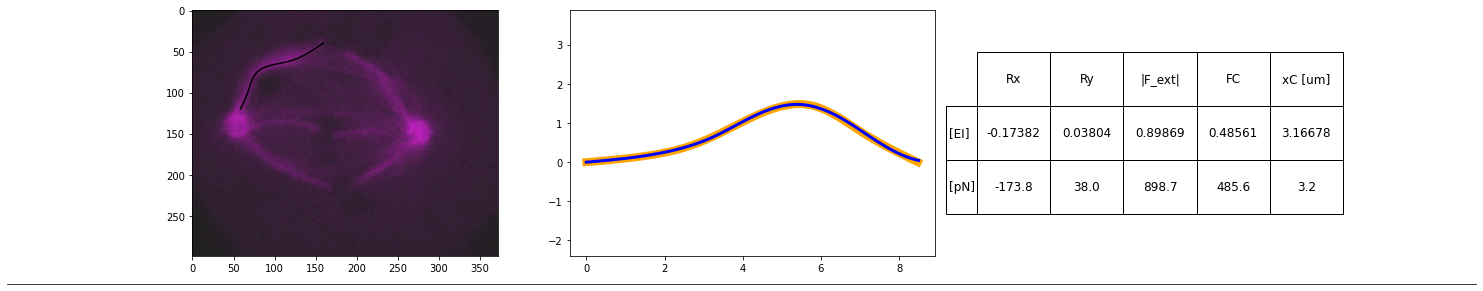

1
20171215_cell004b


  0%|          | 0/25000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 25000/25000 [08:22<00:00, 49.79it/s]


Rx, M0, Ry, theta0, F, xF_var, xC, FC
[-0.429, 0.0, -0.074, 0.297, 1.451, 5.003, 2.48, 0.583]
RMSE: 0.0379
Max gap: 0.0666


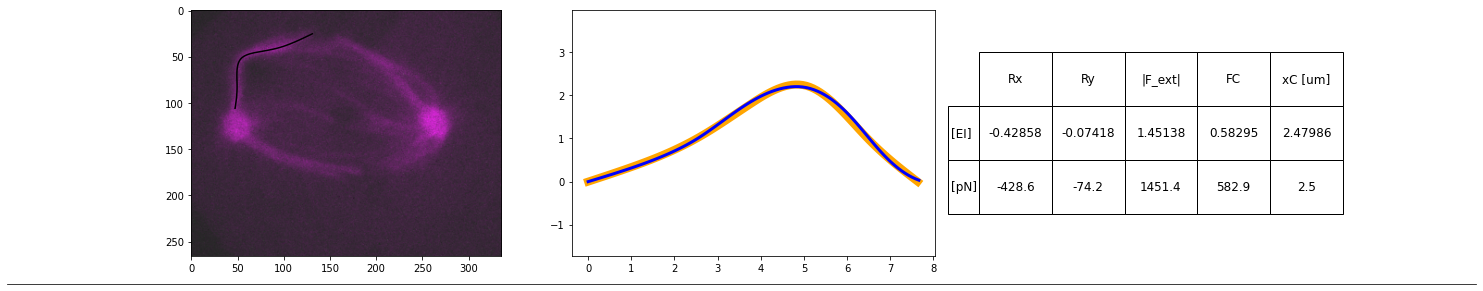

3
20180611_cell002


  0%|          | 0/25000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 25000/25000 [07:57<00:00, 52.37it/s]


Rx, M0, Ry, theta0, F, xF_var, xC, FC
[-0.239, -0.834, 0.018, 0.358, -0.89, 4.6, 1.69, 0.503]
RMSE: 0.0233
Max gap: 0.0387


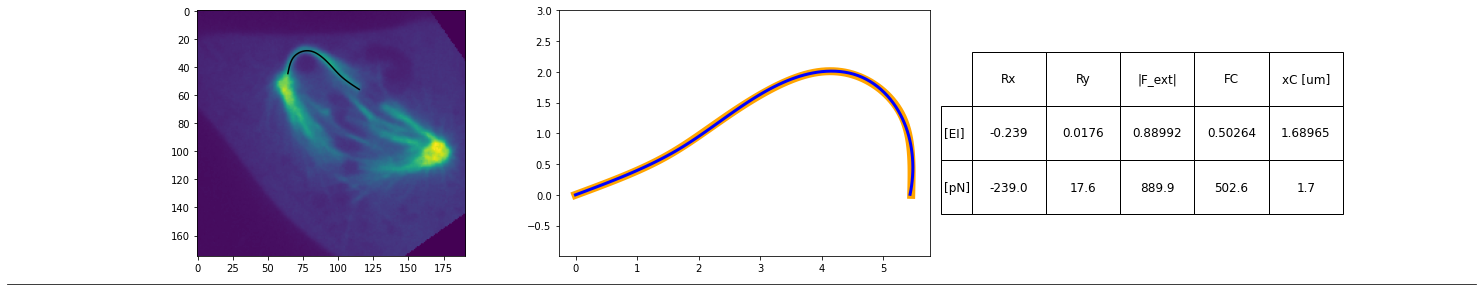

4
20180620_cell013


  0%|          | 0/25000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 25000/25000 [08:16<00:00, 50.37it/s]


Rx, M0, Ry, theta0, F, xF_var, xC, FC
[-0.294, 0.011, 0.247, 0.163, -1.32, 4.694, 1.286, 0.811]
RMSE: 0.0238
Max gap: 0.0468


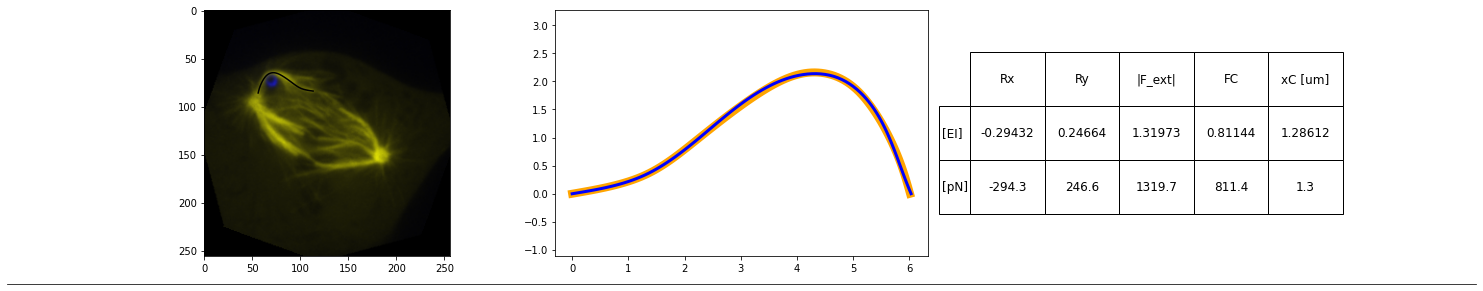

5
20180622_cell016


  0%|          | 0/25000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 25000/25000 [08:23<00:00, 49.70it/s]


Rx, M0, Ry, theta0, F, xF_var, xC, FC
[-0.197, 0.0, -0.087, 0.462, -3.228, 5.267, 4.183, 1.813]
RMSE: 0.0383
Max gap: 0.0867


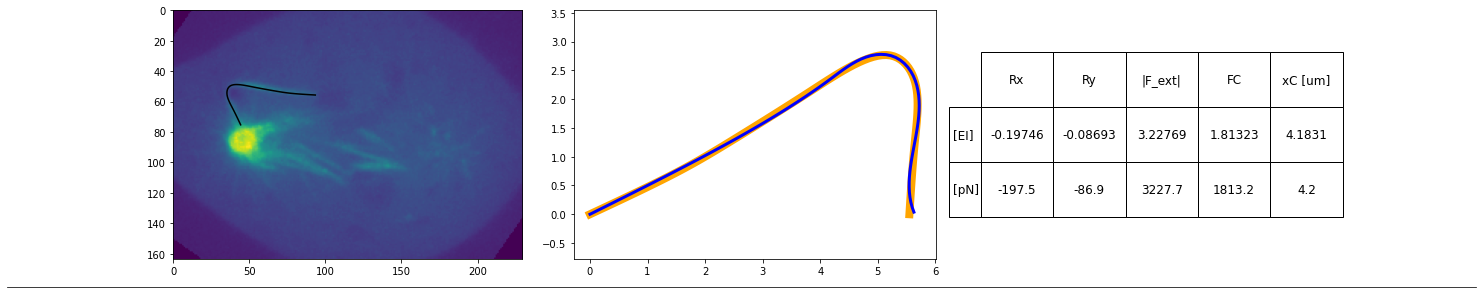

6
20180622_cell020


  0%|          | 0/25000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 25000/25000 [07:47<00:00, 53.53it/s]


Rx, M0, Ry, theta0, F, xF_var, xC, FC
[-0.014, 0.009, 0.033, 0.264, -1.67, 6.316, 4.266, 0.875]
RMSE: 0.0552
Max gap: 0.0968


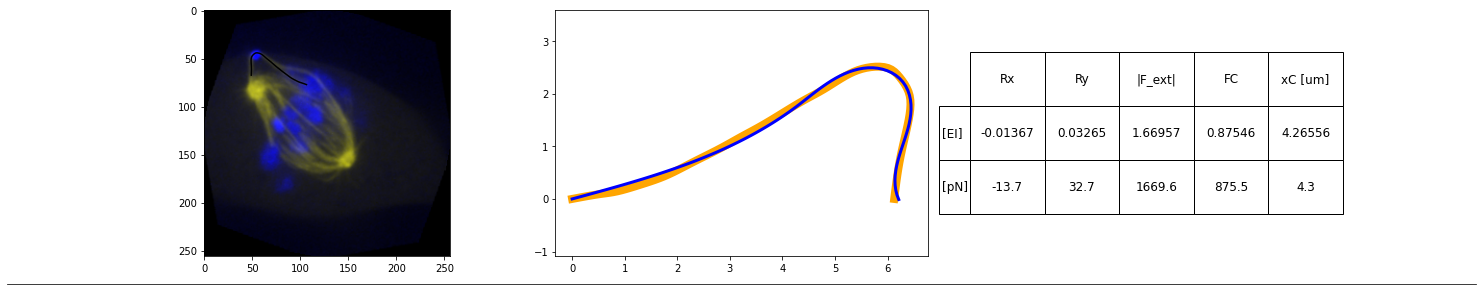

7
20180622_cell031


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 25000/25000 [07:58<00:00, 52.25it/s]


Rx, M0, Ry, theta0, F, xF_var, xC, FC
[-0.026, -0.548, 0.089, 0.072, 1.316, 5.649, 3.335, 0.81]
RMSE: 0.0277
Max gap: 0.0421


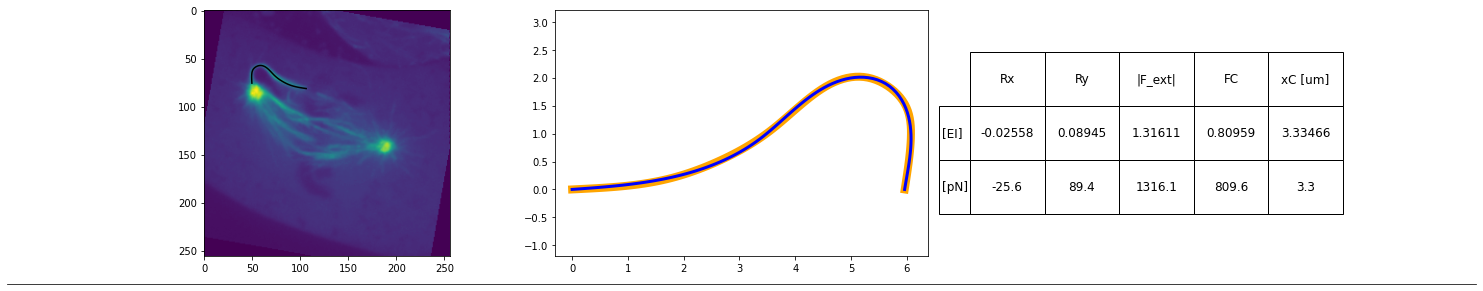

8
20180628_cell002


  0%|          | 0/25000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 25000/25000 [08:14<00:00, 50.60it/s]


Rx, M0, Ry, theta0, F, xF_var, xC, FC
[-0.788, 0.0, -0.135, 0.221, 1.517, 6.092, 2.259, 0.41]
RMSE: 0.0279
Max gap: 0.0568


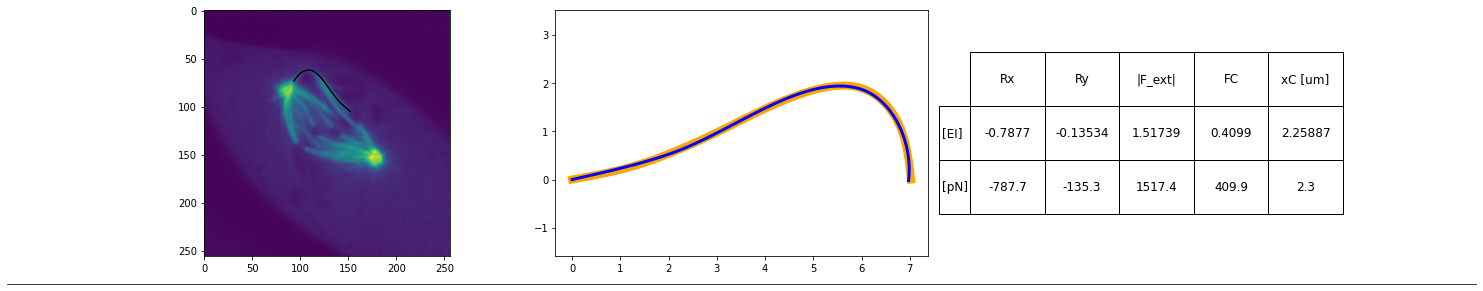

10
20180628_cell010


  0%|          | 0/25000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 25000/25000 [08:10<00:00, 51.01it/s]


Rx, M0, Ry, theta0, F, xF_var, xC, FC
[-0.286, 59.049, 0.054, 0.336, 1.021, 4.807, 1.335, 0.484]
RMSE: 0.0216
Max gap: 0.0399


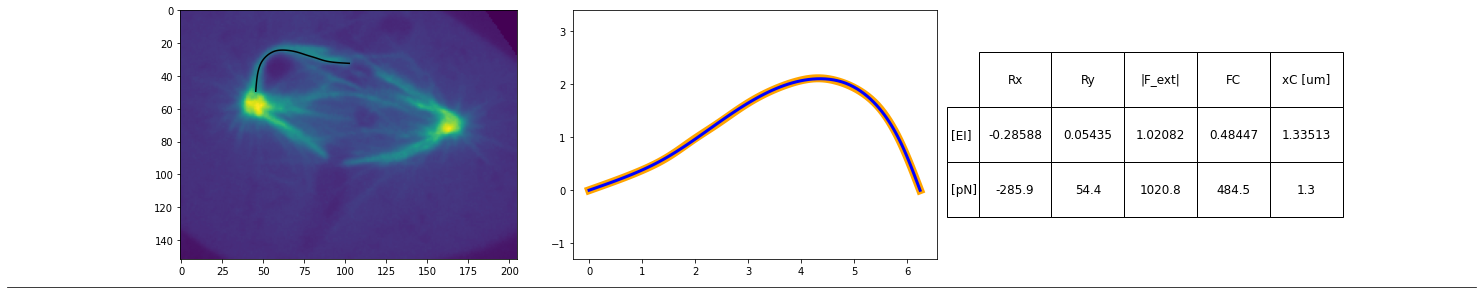

12
20180926_cell007


  0%|          | 0/25000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 25000/25000 [08:02<00:00, 51.83it/s]


Rx, M0, Ry, theta0, F, xF_var, xC, FC
[-0.268, 0.007, 0.115, 0.459, -1.517, 3.23, 1.112, 0.889]
RMSE: 0.0226
Max gap: 0.0347


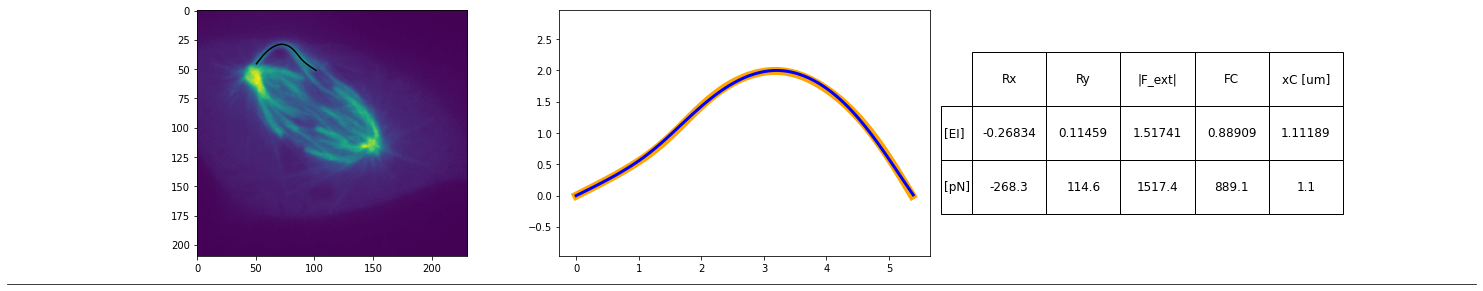

15
20190110_cell008


  0%|          | 0/25000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 25000/25000 [08:23<00:00, 49.70it/s]


Rx, M0, Ry, theta0, F, xF_var, xC, FC
[-0.59, -0.002, -0.436, 0.684, 3.442, 3.16, 1.978, -1.44]
RMSE: 0.0360
Max gap: 0.0727


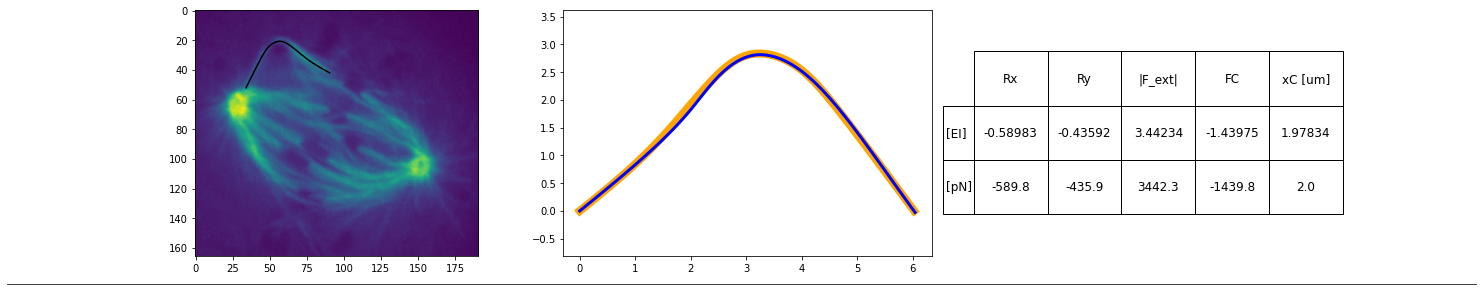

17
20190927_cell008


  0%|          | 0/25000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 25000/25000 [08:45<00:00, 47.58it/s]


Rx, M0, Ry, theta0, F, xF_var, xC, FC
[-0.198, -0.068, -0.053, 0.546, 1.488, 4.402, 2.427, 0.733]
RMSE: 0.0344
Max gap: 0.0764


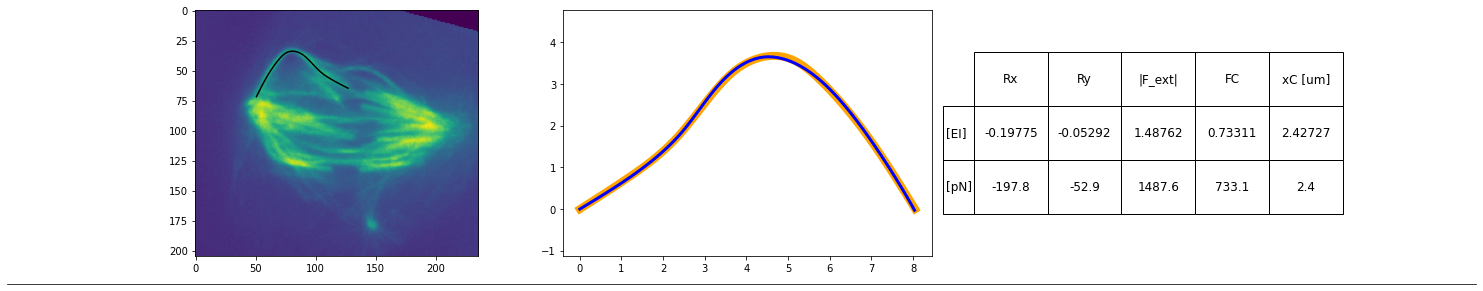

In [35]:
df_fin = pd.DataFrame()

sigma_xF = 0.5
path = "../../dat/WT_manip_20210722/"
cells = sorted(glob.glob("%s/*"%path))


n_steps = 5000
n_steps_Mk = 1500
sigma_start = 0.001 # standard deviation of the random multiplying factor centered
                    # around 1, used to randomize the initial positions of the walkers
sigma_start_noise = 0.01

for n, cell in enumerate(cells):
    if n in [2,9,11,13,14,16,18,19,20]:
        continue
    print(n)
    
#     if n not in [1,2]:
#         continue
        
#     if n != 1:
#         continue

#     if n in [5, 7]:
#         continue


    # Show the spindle image & overlaid k-fiber profile    
    spindle = cell.split("/")[-1].split(".")[0]
    image = mpimg.imread("%s/%s_after.tif"%(cell,spindle))
    profile = glob.glob("%s/kfiber.csv"%cell)[0]

    df_dat = pd.read_csv(profile)
    
    
    
    x_dat = df_dat["X"].values
    y_dat = df_dat["Y"].values

    print(spindle)
    fig, ax = plt.subplots(1, 3, figsize = (17, 4))

    ax[0].imshow(image)
    ax[0].plot(x_dat, y_dat, color = 'k')
    
    angle = np.arctan((y_dat[-1] - y_dat[0]) / (x_dat[-1] - x_dat[0]))
    x_dat,y_dat = rotate(x_dat,y_dat,angle)
    
    # Translation to start at origin
    x_dat -= x_dat[0]
    y_dat -= y_dat[0]
    
    # Flipping to ensure a positive initial slope
    theta0 = np.arctan2(y_dat[3]-y_dat[0], x_dat[3]-x_dat[0])
    if theta0 < 0.0:
        y_dat = -y_dat
        angle = -angle
    
    # Convert from pixel to micron units based on scope camera calibration
    is_2017 = re.search('2017',cell)
    if is_2017:
        scope_calibration = 1/0.0657
    else:
        scope_calibration = 1/0.105
    
    x_dat = x_dat/scope_calibration
    y_dat = y_dat/scope_calibration
    
    # P-K distance
    L = x_dat[-1] - x_dat[0]
    
    
    # Flip the profile
    y_dat = np.flip(y_dat)
    x_dat = L - np.flip(x_dat)
    
    
    
    # Initial angle
    theta0 = np.arctan2(y_dat[3]-y_dat[0], x_dat[3]-x_dat[0])
    
    y_needle = np.max(y_dat)
    x_needle = x_dat[np.where(y_dat == np.max(y_dat))]
    xF = x_needle[0]
    
    
    
    
    M0_zero = True
    length_conserved = False
    end_to_end = np.inf
    xF_fixed = True
    
    error_min = np.inf
    
    M0_init = 0
    theta_peak = np.arctan(y_dat[y_dat==y_dat.max()]/x_dat[y_dat==y_dat.max()])[0]
    theta0_init = theta_peak
    
    for F_init in tqdm(np.logspace(-1, 0.5, 6)):
        for Rx_init in -np.linspace(0.25, 1.25, 4)*F_init:
            for Ry_init in -np.linspace(0.025, 0.375, 3)*F_init:
                
                param_init = np.array([Rx_init, M0_init, Ry_init, theta0_init, F_init, xF])
                args = (x_dat, y_dat, xF, sigma_xF, length_conserved, M0_zero, xF_fixed, end_to_end)
                
                output = scipy.optimize.least_squares(res_fn_exact, param_init, args=args, method="lm")
                if error_min > output.cost:
                    p_opt = output.x
                    error_min = output.cost

    xF_fixed = False
    args = (x_dat, y_dat, xF, sigma_xF, length_conserved, M0_zero, xF_fixed, end_to_end)
    p_opt[5] = xF
    output = scipy.optimize.least_squares(res_fn_exact, p_opt, args=args, method="lm")
    p_opt = output.x
    
    end_to_end = 0.02
    args = (x_dat, y_dat, xF, sigma_xF, length_conserved, M0_zero, xF_fixed, end_to_end)
    output = scipy.optimize.least_squares(res_fn_exact, p_opt, args=args, method="lm")
    p_opt = output.x
    
    
    output_deflection = deflection_exact(p_opt, x_dat, y_dat, xF, sigma_xF, length_conserved,\
                                         M0_zero, xF_fixed)
    x_mod, y_mod, M_mod, xF_final, yF, thetaF = output_deflection
    
    _, ind_pairs = distances_pair_min(x_dat, y_dat, x_mod, y_mod)
    ind_pairs = ind_pairs.astype('int')
    x_mod_truncated = x_mod[:ind_pairs[-1]+1]
    y_mod_truncated = y_mod[:ind_pairs[-1]+1]
    
#     plt.plot(x_dat, y_dat, color="orange", lw = 8)
#     plt.plot(x_mod_truncated, y_mod_truncated, color = "blue", lw = 3)
#     plt.title('n = ' + str(n))
    
    
    
    # ----------------- Parameter inference: MCMC (Mk=0) ----------------- #
    
    n_dim = 6        # number of parameters in the model
    n_walkers = 15   # number of MCMC walkers
    cols = ['Rx', 'M0', 'Ry', 'theta0', 'F', 'xF_var']


    p_init = np.copy(p_opt)
    p_init_mat = np.tile(p_init, (n_walkers, 1))
    np.random.seed(1)
    end_to_end = 0.02
    args = (x_dat, y_dat, xF, sigma_xF, length_conserved, M0_zero, xF_fixed, end_to_end)
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, logpost_exact, args=args, threads=3)
    
    p_opt_mat = p_init_mat
    for j in range(n_dim):
        p_opt_mat[:,j] *= np.random.normal(1.0, sigma_start, n_walkers)
        p_opt_mat[:,j] += np.random.normal(1e-4, 1e-5, n_walkers)
    _ = sampler.run_mcmc(p_opt_mat, n_steps, progress=True)
    df_mcmc = sampler_to_dataframe(sampler, columns=cols)
    p_opt_mcmc = df_mcmc[df_mcmc['lnprob']==df_mcmc['lnprob'].max()].values[0][:-2]
    
    output_deflection_mcmc = deflection_exact(p_opt_mcmc, x_dat, y_dat, xF, sigma_xF, length_conserved,\
                                              M0_zero, xF_fixed)
    
    x_mod_mcmc = output_deflection_mcmc[0]
    y_mod_mcmc = output_deflection_mcmc[1]
    
    _, ind_pairs = distances_pair_min(x_dat, y_dat, x_mod_mcmc, y_mod_mcmc)
    ind_pairs = ind_pairs.astype('int')
    x_mod_mcmc_truncated = x_mod_mcmc[:ind_pairs[-1]+1]
    y_mod_mcmc_truncated = y_mod_mcmc[:ind_pairs[-1]+1]
    
#     plt.plot(x_mod_mcmc_truncated, y_mod_mcmc_truncated, color='green', ls='--', lw=2.0)
    
    
#     plt.axis('equal')
#     plt.show()
    
#     print('Rx, M0, Ry, theta0, F, xF_var')
#     print([np.round(x,3) for x in p_opt_mcmc])
    
    
#     # ----------------- Parameter inference: least squares (Mk≠0) ----------------- #
#     plt.plot(x_dat, y_dat, color="orange", lw = 8)
#     plt.title('n = ' + str(n))
    
#     M0_zero = False
#     error_min = np.inf
#     theta0_init = theta0
    
#     Rx, M0, Ry, theta0, F, xF_var = p_opt_mcmc
    
#     for M0_init in [-0.2, -0.02]:
#         for F_init in tqdm(np.linspace(0.95, 1.05, 3)*F):
#             for Rx_init in np.linspace(0.95, 1.05, 3)*Rx:
#                 for Ry_init in np.linspace(0.95, 1.05, 3)*Ry:
                    
#                     param_init = np.array([Rx_init, M0_init, Ry_init, theta0_init, F_init, xF])
#                     args = (x_dat, y_dat, xF, sigma_xF, length_conserved, M0_zero, xF_fixed, end_to_end)
                    
#                     output = scipy.optimize.least_squares(res_fn_exact, param_init, args=args, method="lm")
#                     if error_min > output.cost:
#                         p_opt_Mk = output.x
#                         error_min = output.cost
    
#     output_deflection = deflection_exact(p_opt_Mk, x_dat, y_dat, xF, sigma_xF, length_conserved,\
#                                          M0_zero, xF_fixed)
#     x_mod_Mk, y_mod_Mk, M_mod, xF_final, yF, thetaF = output_deflection
#     plt.plot(x_mod_Mk, y_mod_Mk, color='k', lw=2.0)
    
    
#     # ----------------- Parameter inference: MCMC (Mk≠0) ----------------- #
#     p_init = np.copy(p_opt_Mk)
#     p_init_mat = np.tile(p_init, (n_walkers, 1))
    
#     args = (x_dat, y_dat, xF, sigma_xF, length_conserved, M0_zero, xF_fixed, end_to_end)
#     sampler = emcee.EnsembleSampler(n_walkers, n_dim, logpost_exact, args=args, threads=3)

#     np.random.seed(1)
#     p_opt_mat = p_init_mat
#     for j in range(n_dim):
#         p_opt_mat[:,j] *= np.random.normal(1.0, sigma_start, n_walkers)
#     _ = sampler.run_mcmc(p_opt_mat, n_steps_Mk, progress=True)
#     df_mcmc = sampler_to_dataframe(sampler, columns=cols)
#     p_opt_Mk_mcmc = df_mcmc[df_mcmc['lnprob']==df_mcmc['lnprob'].max()].values[0][:-2]
    
#     output_deflection_mcmc_Mk = deflection_exact(p_opt_Mk_mcmc, x_dat, y_dat, xF, sigma_xF, length_conserved,\
#                                                  M0_zero, xF_fixed)
#     x_mod_mcmc_Mk = output_deflection_mcmc_Mk[0]
#     y_mod_mcmc_Mk = output_deflection_mcmc_Mk[1]
#     plt.plot(x_mod_mcmc_Mk, y_mod_mcmc_Mk, color='k', lw=2.0, ls='--')
    
#     plt.axis('equal')
    
#     print('Rx, M0, Ry, theta0, F, xF_var')
#     print([np.round(x,3) for x in p_opt_Mk_mcmc])
    
    
    # ----------------- Parameter inference: FC ----------------- #
#     fig, ax = plt.subplots()
#     plt.plot(x_dat, y_dat, color="orange", lw = 8)
#     plt.title('n = ' + str(n))
    
    
#     Rx, M0, Ry, theta0_inf, F, xF_var = p_opt_mcmc
    
    
    M0_zero = True
#     error_min = np.inf
#     theta0_init = theta0
#     xC_init = 1.5
#     xF_init = xF_var
    
#     for theta0_init in [0.75*theta0_inf, 1.00*theta0_inf]:
#         for FC_init in [0, 0.4]:
#             for F_init in tqdm(np.linspace(0.95, 1.05, 3)*F):
#                 for Rx_init in np.linspace(0.95, 1.05, 3)*Rx:
#                     for Ry_init in np.linspace(0.95, 1.05, 3)*Ry:

#                         param_init = np.array([Rx_init, 0, Ry_init, theta0_init, F_init, xF_init, xC_init, FC_init])
#                         args = (x_dat, y_dat, xF, sigma_xF, length_conserved, M0_zero, end_to_end)

#                         output = scipy.optimize.least_squares(res_fn_exact_FC, param_init, args=args, method="lm")
#                         if error_min > output.cost:
#                             p_opt_FC = output.x
#                             error_min = output.cost
    
#     output_deflection = deflection_exact_FC(p_opt_FC, x_dat, y_dat, xF, sigma_xF, length_conserved,\
#                                             M0_zero)
#     x_mod_FC, y_mod_FC, M_mod, xF_final, yF, thetaF = output_deflection
#     plt.plot(x_mod_FC, y_mod_FC, color='k', lw=2.0)

#     print('Rx, M0, Ry, theta0, F, xF_var, xC, FC')
#     print([np.round(x,3) for x in p_opt_FC])
    
    
    # ----------------- Parameter inference: MCMC (Mk≠0) ----------------- #
    cols = ['Rx', 'M0', 'Ry', 'theta0', 'F', 'xF_var', 'xC', 'FC']
    n_dim_FC = 8
    n_walkers_FC = 24
    n_steps_FC = 25000
    end_to_end = 0.005
    M0_zero = True
    
    p_init = np.concatenate([np.copy(p_opt_mcmc), np.array([1.0, 0.1])])
    p_init[0] = -0.1
    xF_var = p_opt_mcmc[-1]
    if np.abs(xF_var - xF) > sigma_xF:
        xF_var = xF + (sigma_xF*np.sign(xF_var - xF))
    p_init[5] = xF_var
    
    p_init_mat = np.tile(p_init, (n_walkers_FC, 1))
    
    args = (x_dat, y_dat, xF, sigma_xF, length_conserved, M0_zero, end_to_end)
    sampler = emcee.EnsembleSampler(n_walkers_FC, n_dim_FC, logpost_exact_FC, args=args, threads=3)
    
    np.random.seed(1)
    p_opt_mat = p_init_mat
    for j in range(n_dim_FC):
        p_opt_mat[:,j] *= np.random.normal(1.0, 0.05, n_walkers_FC)
    _ = sampler.run_mcmc(p_opt_mat, n_steps_FC, progress=True)
    df_mcmc = sampler_to_dataframe(sampler, columns=cols)
    p_opt_FC_mcmc = df_mcmc[df_mcmc['lnprob']==df_mcmc['lnprob'].max()].values[0][:-2]
    
    output_deflection_mcmc_FC = deflection_exact_FC(p_opt_FC_mcmc, x_dat, y_dat, xF, sigma_xF, length_conserved,\
                                                    M0_zero)
    x_mod_mcmc_FC = output_deflection_mcmc_FC[0]
    y_mod_mcmc_FC = output_deflection_mcmc_FC[1]
    M_mod_mcmc_FC = output_deflection_mcmc_FC[2]
    
    _, ind_pairs = distances_pair_min(x_dat, y_dat, x_mod_mcmc_FC, y_mod_mcmc_FC)
    ind_pairs = ind_pairs.astype('int')
    x_mod_mcmc_FC_truncated = x_mod_mcmc_FC[:ind_pairs[-1]+1]
    y_mod_mcmc_FC_truncated = y_mod_mcmc_FC[:ind_pairs[-1]+1]
    M_mod_mcmc_FC_truncated = M_mod_mcmc_FC[:ind_pairs[-1]+1]
    
    ax[1].plot(x_dat, y_dat, color="orange", lw = 8)
    ax[1].plot(x_mod_mcmc_FC_truncated, y_mod_mcmc_FC_truncated, color='blue', lw=3.0)
    ax[1].axis('equal')

    
    table_data = [[round(i,5) for i in [p_opt_FC_mcmc[0], p_opt_FC_mcmc[2], abs(p_opt_FC_mcmc[4]), p_opt_FC_mcmc[7], p_opt_FC_mcmc[6]]],\
                  [round(i,1) for i in [p_opt_FC_mcmc[0]*1e3, p_opt_FC_mcmc[2]*1e3, abs(p_opt_FC_mcmc[4])*1e3, p_opt_FC_mcmc[7]*1e3, p_opt_FC_mcmc[6]]]]

    table = ax[2].table(cellText=table_data, colLabels=['Rx', 'Ry', '|F_ext|', 'FC', 'xC [um]'], loc='center', 
                        rowLabels=['[EI]', '[pN]'], cellLoc='center')

    table.scale(1,4)
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    ax[2].axis('off')

    
    print('Rx, M0, Ry, theta0, F, xF_var, xC, FC')
    print([np.round(x,3) for x in p_opt_FC_mcmc])

    
    # --------- Error metrics --------- #
    
    res_exact, _ = distances_pair_min(x_dat, y_dat, x_mod_mcmc_FC_truncated, y_mod_mcmc_FC_truncated)
    err_exact = np.sqrt(np.mean(res_exact**2))

    # Largest y-deflections
    gap_max_exact = np.max(res_exact)

    if show_details:
        print("RMSE: %.4f"%err_exact)
        print("Max gap: %.4f"%gap_max_exact)

    df_fin = df_fin.append({'Spindle': spindle,
                            'x_dat': x_dat,
                            'y_dat': y_dat,
                            'L': L,
                            'x (exact)': x_mod_mcmc_FC_truncated,
                            'y (exact)': y_mod_mcmc_FC_truncated,
                            'M (exact)': M_mod_mcmc_FC_truncated,
                            'Rx (exact)': p_opt_FC_mcmc[0],
                            'M0 (exact)': 0.0,
                            'Ry (exact)': p_opt_FC_mcmc[2],
                            'theta0 (exact)': p_opt_FC_mcmc[3],
                            'F (exact)': p_opt_FC_mcmc[4],
                            'thetaF (exact)': output_deflection_mcmc_FC[5],
                            'xC (exact)': p_opt_FC_mcmc[6],
                            'FC (exact)': p_opt_FC_mcmc[7],
                            'xF (exact)': output_deflection_mcmc_FC[3],
                            'yF (exact)': output_deflection_mcmc_FC[4],
                            'gap_max (exact)': gap_max_exact, 
                            'RMSE (exact)': err_exact}, ignore_index=True) 
  
    plt.tight_layout()    
    line = plt.Line2D([-0.1,1.1], [0,0], transform=fig.transFigure, color="black", lw = 0.75)
    fig.add_artist(line)
    plt.show()

In [34]:
print("FC fits")
pkl_name = 'force_FC.pkl'
df_fin.to_pickle(pkl_name)

FC fits


In [ ]:
# xC_init = 2.0
# FC_init = 0.01
# Rx_init = Rx_opt
# M0_init = 1e5
# Ry_init = Ry_opt
# theta0_init = theta0_opt
# F_init = F_opt
# xF_init = xF_opt



# # p_mcmc = np.array([Rx, M0, Ry, theta0, F, xF, xC, FC])

# length_conserved = False
# end_match = False
# M0_zero = True

# if n==0:
#     p_mcmc = np.array([-6.09412389e-01, -9.03422087e+01, -7.82310908e-02,  1.93568401e-01,
#                        -1.01458394e+00,  5.49533607e+00,  2.49315635e+00,  4.12598290e-01])
# elif n==1:
#     p_mcmc = np.array([-0.62397266,   5.70264011,  -0.05769978,   0.25821882,
#                         1.67328158,   4.62798007,   1.90316205,   0.7380843])
# elif n==2:
#     p_mcmc = np.array([-0.23266218,  0.50601652,  0.10848743,  0.36072373,  0.7464032 ,
#                         4.98798715,  1.22111608,  0.48923246])
# elif n==3:
#     p_mcmc = np.array([-1.30743247e-01, -3.93350056e+05,  4.44981790e-01,  2.56502336e-01,
#                         8.61470869e-01,  4.72392525e+00,  8.21061583e-01,  8.53081029e-01])
# elif n==4:
#     p_mcmc = np.array([-3.36690748e-01,  7.78617265e+03,  3.90323169e-01,  1.74620280e-01,
#                         1.39632545e+00,  4.75345564e+00,  8.95434749e-01,  9.18206878e-01])
# elif n==5:
#     p_mcmc = np.array([-0.82382336,  1.12602874, -0.34647815,  0.41005571, -2.96837728,
#                         5.66736376,  3.41776434,  0.7978696])
# elif n==6:
#     p_mcmc = np.array([-1.97395838e-02, -6.43787623e+02,  2.65541519e-02,  4.08015200e-01,
#                        -2.99771839e+00,  5.48920824e+00,  4.41040238e+00,  1.83931817e+00])
# elif n==7:
#     p_mcmc = np.array([-4.32353424e-01,  4.14473863e+00,  1.71639645e-02,  8.45305132e-02,
#                        -2.38547450e+00,  5.63546962e+00,  3.50500693e+00,  1.20291030e+00])

p_mcmc = np.array([-1.97395838e-02, -6.43787623e+02,  2.65541519e-02,  4.08015200e-01,
                    -2.99771839e+00,  5.48920824e+00,  4.41040238e+00,  1.83931817e+00])
                   
                   
xC_opt = p_mcmc[-2]
print('xC: %.3f' % xC_opt)
FC_opt = p_mcmc[-1]
print('FC: %.3f' % FC_opt)
res = res_fn_exact_FC(p_mcmc, x_dat, y_dat, xF, sigma_xF, \
                      length_conserved=length_conserved, M0_zero=M0_zero, end_match=end_match)
print('Error (um): %.5f' % np.mean(res))

output_deflection = deflection_exact_FC(p_mcmc, x_dat, y_dat, xF, sigma_xF, length_conserved, M0_zero)
x_mod_FC, y_mod_FC, M_mod_FC, _, _, _ = output_deflection

_, ind_pairs = distances_pair_min(x_dat, y_dat, x_mod_FC, y_mod_FC)
ind_pairs = ind_pairs.astype('int')
x_mod_FC_truncated = x_mod_FC[:ind_pairs[-1]+1]
y_mod_FC_truncated = y_mod_FC[:ind_pairs[-1]+1]
M_mod_FC_truncated = M_mod_FC[:ind_pairs[-1]+1]

x_curve_min = x_mod_FC[np.where(M_mod_FC_truncated[x_mod_FC_truncated < xF] == \
                                M_mod_FC_truncated[x_mod_FC_truncated < xF].min())]
print('x_curve_min (model): %.3f' % x_curve_min)

plt.scatter(x_dat, y_dat)
plt.plot(x_mod_FC_truncated, y_mod_FC_truncated, color='k', lw=3.0)
plt.axis('equal')
plt.show()



# Rx_init = p_mcmc[0]
# M0_init = p_mcmc[1]
# Ry_init = p_mcmc[2]
# theta0_init = p_mcmc[3]
# F_init = p_mcmc[4]
# xF_init = p_mcmc[5]
# xC_init = p_mcmc[6]
# FC_init = p_mcmc[7]



def logpost_exact(param, x_dat, y_dat, xF, sigma_xF, \
                  length_conserved=True, M0_zero=False, end_match=False):
    
    Rx, M0, Ry, theta0, F, xF_var, xC, FC = param
    L = x_dat.max()-x_dat.min()
    
    if np.abs(M0) > 1e10:
        return -np.inf
    if theta0 < 0.0 or theta0 > 1.0:
        return -np.inf
    if Rx > 0:
        return -np.inf
    if (xC < 0) or (xC > L) or (xF_var < 0) or (xF_var>L):
        return -np.inf
    if np.abs(Rx) > 3 or np.abs(Ry) > 1.5 or np.abs(F) > 3 or np.abs(FC) > 3:
        return -np.inf
    
    res = res_fn_exact_FC(param, x_dat, y_dat, xF, sigma_xF, \
                          length_conserved=length_conserved, M0_zero=M0_zero, end_match=end_match)
                          
    return -15*np.log(np.sum(res))
    
    
    
n_dim = 8      # number of parameters in the model
n_walkers = 30   # number of MCMC walkers
n_burn = 500   # "burn-in" period to let chains stabilize
n_steps = 50000   # number of MCMC steps to take after burn-in

sigma_start = 0.01

# p0[i,j] is the starting point for walker i along variable j.    
param_init = np.empty((n_walkers, n_dim))
param_init[:,0] = Rx_init*np.random.normal(1.0, sigma_start, n_walkers)
param_init[:,1] = np.random.normal(1.0, sigma_start, n_walkers)
param_init[:,2] = Ry_init*np.random.normal(1.0, sigma_start, n_walkers)
param_init[:,3] = theta0_init*np.random.normal(1.0, sigma_start, n_walkers)
param_init[:,4] = F_init*np.random.normal(1.0, sigma_start, n_walkers)
param_init[:,5] = xF_init*np.random.normal(1.0, sigma_start, n_walkers)
param_init[:,6] = xC_init*np.random.normal(1.0, sigma_start, n_walkers)
param_init[:,7] = FC_init*np.random.normal(1.0, sigma_start, n_walkers)


args = (x_dat, y_dat, xF, sigma_xF, length_conserved, M0_zero, end_match)

sampler = emcee.EnsembleSampler(n_walkers, n_dim, logpost_exact, 
                                args=args, threads=3)




pos, prob, state = sampler.run_mcmc(param_init, n_burn, progress=True)




sampler = emcee.EnsembleSampler(n_walkers, n_dim, logpost_exact, 
                                args=args, threads=3)
_ = sampler.run_mcmc(pos, n_steps, progress=True)

cols = ['Rx', 'M0', 'Ry', 'theta0', 'F', 'xF_var', 'xC', 'FC']
df_mcmc = sampler_to_dataframe(sampler, columns=cols)

df_mcmc[df_mcmc['lnprob']==df_mcmc['lnprob'].max()]

In [ ]:
sigma_xF = 0.5

rmse_ls = []
xC_ls = []

minC_val_ls, minC_pos_ls = [], []
maxC_val_ls, maxC_pos_ls = [], []
minM_val_ls, minM_pos_ls = [], []
maxM_val_ls, maxM_pos_ls = [], []
inflectionM_val_ls, inflectionM_pos_ls = [], []
inflectionC_val_ls, inflectionC_pos_ls = [], []



for n, kfib in enumerate(fin_track_ls):
        
    if n == 6:
        continue 
        
    cell = cells[n]
    spindle = cell.split("/")[-1].split(".")[0]
    df_dat = pd.read_csv(kfib,engine="python")
    
    x_dat = df_dat["X"].values
    y_dat = df_dat["Y"].values

    
    
    
    angle = np.arctan((y_dat[-1] - y_dat[0]) / (x_dat[-1] - x_dat[0]))
    x_dat,y_dat = rotate(x_dat,y_dat,angle)

    # Translation to start at origin
    x_dat -= x_dat[0]
    y_dat -= y_dat[0]

    # Flipping to ensure a positive initial slope
    theta0 = np.arctan2(y_dat[3]-y_dat[0], x_dat[3]-x_dat[0])
    if theta0 < 0.0:
        y_dat = -y_dat
        angle = -angle

    # Convert from pixel to micron units based on scope camera calibration
    is_2017 = re.search('2017',cell)
    if is_2017:
        scope_calibration = 1/0.0657
    else:
        scope_calibration = 1/0.105

    x_dat = x_dat/scope_calibration
    y_dat = y_dat/scope_calibration
    
    # P-K distance
    L = x_dat[-1] - x_dat[0]
    
    
    # Flip the profile
    y_dat = np.flip(y_dat)
    x_dat = L - np.flip(x_dat)
    
    
    

    # Initial angle
    theta_init = np.arctan2(y_dat[3]-y_dat[0], x_dat[3]-x_dat[0])

    y_needle = np.max(y_dat)
    x_needle = x_dat[np.where(y_dat == np.max(y_dat))]
    xF = x_needle[0]
    
    
    
    
    ################################################
    length_conserved = False
    end_match = False
    M0_zero = True

    if n==0:
        p_mcmc = np.array([-6.09412389e-01, -9.03422087e+01, -7.82310908e-02,  1.93568401e-01,
                           -1.01458394e+00,  5.49533607e+00,  2.49315635e+00,  4.12598290e-01])
    elif n==1:
        p_mcmc = np.array([-0.62397266,   5.70264011,  -0.05769978,   0.25821882,
                            1.67328158,   4.62798007,   1.90316205,   0.7380843])
    elif n==2:
        p_mcmc = np.array([-0.23266218,  0.50601652,  0.10848743,  0.36072373,  0.7464032 ,
                            4.98798715,  1.22111608,  0.48923246])
    elif n==3:
        p_mcmc = np.array([-1.30743247e-01, -3.93350056e+05,  4.44981790e-01,  2.56502336e-01,
                            8.61470869e-01,  4.72392525e+00,  8.21061583e-01,  8.53081029e-01])
    elif n==4:
        p_mcmc = np.array([-3.36690748e-01,  7.78617265e+03,  3.90323169e-01,  1.74620280e-01,
                            1.39632545e+00,  4.75345564e+00,  8.95434749e-01,  9.18206878e-01])
    elif n==5:
        p_mcmc = np.array([-0.82382336,  1.12602874, -0.34647815,  0.41005571, -2.96837728,
                            5.66736376,  3.41776434,  0.7978696])
    elif n==6:
        p_mcmc = np.array([-1.97395838e-02, -6.43787623e+02,  2.65541519e-02,  4.08015200e-01,
                           -2.99771839e+00,  5.48920824e+00,  4.41040238e+00,  1.83931817e+00])
    elif n==7:
        p_mcmc = np.array([-4.32353424e-01,  4.14473863e+00,  1.71639645e-02,  8.45305132e-02,
                           -2.38547450e+00,  5.63546962e+00,  3.50500693e+00,  1.20291030e+00])
    
    
    xC_opt = p_mcmc[-2]
#     print('xC: %.3f' % xC_opt)
    FC_opt = p_mcmc[-1]
#     print('FC: %.3f' % FC_opt)
    res = res_fn_exact_FC(p_mcmc, x_dat, y_dat, xF, sigma_xF, \
                          length_conserved=length_conserved, M0_zero=M0_zero, end_match=end_match)
    rmse = np.sqrt(np.mean(res**2))
#     print('Error (um): %.5f' % rmse)
    
    output_deflection = deflection_exact_FC(p_mcmc, x_dat, y_dat, xF, sigma_xF, length_conserved, M0_zero)
    x_mod, y_mod, M_mod, _, _, _ = output_deflection

    _, ind_pairs = distances_pair_min(x_dat, y_dat, x_mod, y_mod)
    ind_pairs = ind_pairs.astype('int')
    x_mod = x_mod[:ind_pairs[-1]+1]
    y_mod = y_mod[:ind_pairs[-1]+1]
    M_mod = M_mod[:ind_pairs[-1]+1]
    
#     print('\n')
    rmse_ls.append(rmse)
    xC_ls.append(xC_opt)
    
    iF_mod = np.where(x_mod > xF)[0][0]
    iF_dat = np.where(x_dat > xF)[0][0]

    s_dat, L_contour_dat = contour_fn(x_dat,y_dat)
    s_mod, L_contour_mod = contour_fn(x_mod,y_mod)

    M_max_ind = np.where(M_mod == np.max(M_mod))[0][0]
    M_min_ind = np.where(M_mod == np.min(M_mod[0:iF_mod]))[0][0]
    M_inflection_ind = np.where(np.abs(M_mod) == np.min(np.abs(M_mod[M_min_ind:iF_mod])))[0][0]

    window = 10
    C_dat = curvature(x_dat, y_dat,window)

    
    C_max_ind = np.where(C_dat == np.max(C_dat))[0][0] #+window
    C_min_ind = np.where(C_dat == np.min(C_dat[0:iF_dat-window]))[0][0]#+window
    C_inflection_ind = np.where(np.abs(C_dat) == np.min(np.abs(C_dat[C_min_ind:iF_dat-window])))[0][0]#+window

#     print(s_dat[C_min_ind])
    minM_val_ls.append(M_mod[M_min_ind])
    minM_pos_ls.append(x_mod[M_min_ind])
    maxM_val_ls.append(M_mod[M_max_ind])
    maxM_pos_ls.append(x_mod[M_max_ind])
    minC_val_ls.append(C_dat[C_min_ind])
    minC_pos_ls.append(x_dat[C_min_ind+window])
    maxC_val_ls.append(C_dat[C_max_ind])
    maxC_pos_ls.append(x_dat[C_max_ind+window])
    inflectionM_val_ls.append(M_mod[M_inflection_ind])
    inflectionM_pos_ls.append(s_mod[M_inflection_ind])
    inflectionC_val_ls.append(C_dat[C_inflection_ind])
    inflectionC_pos_ls.append(s_dat[C_inflection_ind+window])
    
    
    
    
    
#     M0_zero = True
#     length_conserved = False
#     end_match = False
#     error_min = np.inf
    
#     for F_init in tqdm(np.logspace(-1,1,5)):
#         for Ry_init in np.concatenate((-np.logspace(-2,0,5),np.logspace(-2,0,5))):
#             for Rx_init in -np.logspace(-2,0,5):
#                 param_init = np.array([Rx_init, 0, Ry_init, theta_init, F_init, xF])
#                 args = (x_dat, y_dat, xF, sigma_xF, length_conserved, M0_zero, end_match)

#                 output = scipy.optimize.least_squares(res_fn_exact, param_init, args=args, method="lm")
#                 if error_min > output.cost:
#                     p_opt = output.x
#                     error_min = output.cost
    
    
#     length_conserved = True
#     end_match = True
#     param_init = p_opt
#     args = (x_dat, y_dat, xF, sigma_xF, length_conserved, M0_zero, end_match)
#     output = scipy.optimize.least_squares(res_fn_exact, param_init, args=args, method="lm")
#     p_opt = output.x

#     print(p_opt)
    
#     M0_zero = True
#     end_match = True
#     Rx_opt, M0_opt, Ry_opt, theta0_opt, F_opt, xF_opt = p_opt
    
#     xC_init = 2.0
#     FC_init = 0
#     Rx_init = Rx_opt
#     M0_init = 0
#     Ry_init = Ry_opt
#     theta0_init = theta0_opt
#     F_init = F_opt
#     xF_init = xF_opt
    

    
#     output_deflection = deflection_exact(p_opt, x_dat, y_dat, xF, sigma_xF, length_conserved)
#     x_mod, y_mod, M_mod, xF_final, yF, thetaF = output_deflection
    
#     _, ind_pairs = distances_pair_min(x_dat, y_dat, x_mod, y_mod)
#     ind_pairs = ind_pairs.astype('int')
#     x_mod_truncated = x_mod[:ind_pairs[-1]+1]
#     y_mod_truncated = y_mod[:ind_pairs[-1]+1]
    
#     plt.plot(x_dat,y_dat, color="orange", lw = 8)
#     plt.plot(x_mod_truncated, y_mod_truncated, color = "blue", lw = 3)
    
    
#     plt.xticks(fontsize=10)
#     plt.yticks(fontsize=10)

    
#     Rx_opt, M0_opt, Ry_opt, theta0_opt, F_opt, _ = p_opt
#     F_opt = np.abs(F_opt)
#     Fx_opt = F_opt * np.cos(thetaF)
#     Fy_opt = F_opt * np.sin(thetaF)

#     plt.axvline(xF, color='k', ls='--', alpha=0.4)

#     quiver_scale=1
#     plt.quiver(0, 0, Rx_opt, Ry_opt, color='k', scale=quiver_scale, zorder = 20)
#     plt.quiver(xF_final, yF, Fx_opt, abs(Fy_opt), color='k', scale=quiver_scale, zorder = 20)
# #     plt.quiver(L,0,-(Rx_opt+Fx_opt),-(Ry_opt+Fy_opt), color='k',scale=quiver_scale, zorder = 20)
#     plt.xlabel('x (μm)')
#     plt.ylabel('y (μm)')
#     plt.axis('equal')
    
    
#     df_fin = df_fin.append({'Spindle': spindle,
#                             'x_dat': x_dat,
#                             'y_dat': y_dat,
#                             'x_mod': x_mod,
#                             'y_mod': y_mod,
#                             'M_mod': M_mod,
#                             'L': L,
#                             'Rx': Rx_opt,
#                             'M0': M0_opt,
#                             'Ry': Ry_opt,
#                             'Fx': Fx_opt,
#                             'Fy': Fy_opt,
#                             'xF': xF,
#                             'yF': yF,                            
#                             'theta0': theta0_opt,
#                             'largest-y-diff (error)': y_diff_max, 
#                             'Root-mean-square(error)': err_exact}, ignore_index=True)

#     plt.show()

In [13]:
sigma_xF = 0.5

rmse_ls = []
xC_ls = []

minC_val_ls, minC_pos_ls = [], []
maxC_val_ls, maxC_pos_ls = [], []
minM_val_ls, minM_pos_ls = [], []
maxM_val_ls, maxM_pos_ls = [], []
inflectionM_val_ls, inflectionM_pos_ls = [], []
inflectionC_val_ls, inflectionC_pos_ls = [], []



for n, kfib in enumerate(fin_track_ls):
        
    if n == 6:
        continue 
        
    cell = cells[n]
    spindle = cell.split("/")[-1].split(".")[0]
    df_dat = pd.read_csv(kfib,engine="python")
    
    x_dat = df_dat["X"].values
    y_dat = df_dat["Y"].values

    
    
    
    angle = np.arctan((y_dat[-1] - y_dat[0]) / (x_dat[-1] - x_dat[0]))
    x_dat,y_dat = rotate(x_dat,y_dat,angle)

    # Translation to start at origin
    x_dat -= x_dat[0]
    y_dat -= y_dat[0]

    # Flipping to ensure a positive initial slope
    theta0 = np.arctan2(y_dat[3]-y_dat[0], x_dat[3]-x_dat[0])
    if theta0 < 0.0:
        y_dat = -y_dat
        angle = -angle

    # Convert from pixel to micron units based on scope camera calibration
    is_2017 = re.search('2017',cell)
    if is_2017:
        scope_calibration = 1/0.0657
    else:
        scope_calibration = 1/0.105

    x_dat = x_dat/scope_calibration
    y_dat = y_dat/scope_calibration
    
    # P-K distance
    L = x_dat[-1] - x_dat[0]
    
    
    # Flip the profile
    y_dat = np.flip(y_dat)
    x_dat = L - np.flip(x_dat)
    
    
    

    # Initial angle
    theta_init = np.arctan2(y_dat[3]-y_dat[0], x_dat[3]-x_dat[0])

    y_needle = np.max(y_dat)
    x_needle = x_dat[np.where(y_dat == np.max(y_dat))]
    xF = x_needle[0]
    
    
    
    
    ################################################
    length_conserved = False
    end_match = False
    M0_zero = True

    if n==0:
        p_mcmc = np.array([-6.09412389e-01, -9.03422087e+01, -7.82310908e-02,  1.93568401e-01,
                           -1.01458394e+00,  5.49533607e+00,  2.49315635e+00,  4.12598290e-01])
    elif n==1:
        p_mcmc = np.array([-0.62397266,   5.70264011,  -0.05769978,   0.25821882,
                            1.67328158,   4.62798007,   1.90316205,   0.7380843])
    elif n==2:
        p_mcmc = np.array([-0.23266218,  0.50601652,  0.10848743,  0.36072373,  0.7464032 ,
                            4.98798715,  1.22111608,  0.48923246])
    elif n==3:
        p_mcmc = np.array([-1.30743247e-01, -3.93350056e+05,  4.44981790e-01,  2.56502336e-01,
                            8.61470869e-01,  4.72392525e+00,  8.21061583e-01,  8.53081029e-01])
    elif n==4:
        p_mcmc = np.array([-3.36690748e-01,  7.78617265e+03,  3.90323169e-01,  1.74620280e-01,
                            1.39632545e+00,  4.75345564e+00,  8.95434749e-01,  9.18206878e-01])
    elif n==5:
        p_mcmc = np.array([-0.82382336,  1.12602874, -0.34647815,  0.41005571, -2.96837728,
                            5.66736376,  3.41776434,  0.7978696])
    elif n==6:
        p_mcmc = np.array([-1.97395838e-02, -6.43787623e+02,  2.65541519e-02,  4.08015200e-01,
                           -2.99771839e+00,  5.48920824e+00,  4.41040238e+00,  1.83931817e+00])
    elif n==7:
        p_mcmc = np.array([-4.32353424e-01,  4.14473863e+00,  1.71639645e-02,  8.45305132e-02,
                           -2.38547450e+00,  5.63546962e+00,  3.50500693e+00,  1.20291030e+00])
    
    
    xC_opt = p_mcmc[-2]
#     print('xC: %.3f' % xC_opt)
    FC_opt = p_mcmc[-1]
#     print('FC: %.3f' % FC_opt)
    res = res_fn_exact_FC(p_mcmc, x_dat, y_dat, xF, sigma_xF, \
                          length_conserved=length_conserved, M0_zero=M0_zero, end_match=end_match)
    rmse = np.sqrt(np.mean(res**2))
#     print('Error (um): %.5f' % rmse)
    
    output_deflection = deflection_exact_FC(p_mcmc, x_dat, y_dat, xF, sigma_xF, length_conserved, M0_zero)
    x_mod, y_mod, M_mod, _, _, _ = output_deflection

    _, ind_pairs = distances_pair_min(x_dat, y_dat, x_mod, y_mod)
    ind_pairs = ind_pairs.astype('int')
    x_mod = x_mod[:ind_pairs[-1]+1]
    y_mod = y_mod[:ind_pairs[-1]+1]
    M_mod = M_mod[:ind_pairs[-1]+1]
    
#     print('\n')
    rmse_ls.append(rmse)
    xC_ls.append(xC_opt)
    
    iF_mod = np.where(x_mod > xF)[0][0]
    iF_dat = np.where(x_dat > xF)[0][0]

    s_dat, L_contour_dat = contour_fn(x_dat,y_dat)
    s_mod, L_contour_mod = contour_fn(x_mod,y_mod)

    M_max_ind = np.where(M_mod == np.max(M_mod))[0][0]
    M_min_ind = np.where(M_mod == np.min(M_mod[0:iF_mod]))[0][0]
    M_inflection_ind = np.where(np.abs(M_mod) == np.min(np.abs(M_mod[M_min_ind:iF_mod])))[0][0]

    window = 10
    C_dat = curvature(x_dat, y_dat,window)

    
    C_max_ind = np.where(C_dat == np.max(C_dat))[0][0] #+window
    C_min_ind = np.where(C_dat == np.min(C_dat[0:iF_dat-window]))[0][0]#+window
    C_inflection_ind = np.where(np.abs(C_dat) == np.min(np.abs(C_dat[C_min_ind:iF_dat-window])))[0][0]#+window

#     print(s_dat[C_min_ind])
    minM_val_ls.append(M_mod[M_min_ind])
    minM_pos_ls.append(x_mod[M_min_ind])
    maxM_val_ls.append(M_mod[M_max_ind])
    maxM_pos_ls.append(x_mod[M_max_ind])
    minC_val_ls.append(C_dat[C_min_ind])
    minC_pos_ls.append(x_dat[C_min_ind+window])
    maxC_val_ls.append(C_dat[C_max_ind])
    maxC_pos_ls.append(x_dat[C_max_ind+window])
    inflectionM_val_ls.append(M_mod[M_inflection_ind])
    inflectionM_pos_ls.append(s_mod[M_inflection_ind])
    inflectionC_val_ls.append(C_dat[C_inflection_ind])
    inflectionC_pos_ls.append(s_dat[C_inflection_ind+window])
    
    
    
    
    
#     M0_zero = True
#     length_conserved = False
#     end_match = False
#     error_min = np.inf
    
#     for F_init in tqdm(np.logspace(-1,1,5)):
#         for Ry_init in np.concatenate((-np.logspace(-2,0,5),np.logspace(-2,0,5))):
#             for Rx_init in -np.logspace(-2,0,5):
#                 param_init = np.array([Rx_init, 0, Ry_init, theta_init, F_init, xF])
#                 args = (x_dat, y_dat, xF, sigma_xF, length_conserved, M0_zero, end_match)

#                 output = scipy.optimize.least_squares(res_fn_exact, param_init, args=args, method="lm")
#                 if error_min > output.cost:
#                     p_opt = output.x
#                     error_min = output.cost
    
    
#     length_conserved = True
#     end_match = True
#     param_init = p_opt
#     args = (x_dat, y_dat, xF, sigma_xF, length_conserved, M0_zero, end_match)
#     output = scipy.optimize.least_squares(res_fn_exact, param_init, args=args, method="lm")
#     p_opt = output.x

#     print(p_opt)
    
#     M0_zero = True
#     end_match = True
#     Rx_opt, M0_opt, Ry_opt, theta0_opt, F_opt, xF_opt = p_opt
    
#     xC_init = 2.0
#     FC_init = 0
#     Rx_init = Rx_opt
#     M0_init = 0
#     Ry_init = Ry_opt
#     theta0_init = theta0_opt
#     F_init = F_opt
#     xF_init = xF_opt
    
 
    
#     output_deflection = deflection_exact(p_opt, x_dat, y_dat, xF, sigma_xF, length_conserved)
#     x_mod, y_mod, M_mod, xF_final, yF, thetaF = output_deflection
    
#     _, ind_pairs = distances_pair_min(x_dat, y_dat, x_mod, y_mod)
#     ind_pairs = ind_pairs.astype('int')
#     x_mod_truncated = x_mod[:ind_pairs[-1]+1]
#     y_mod_truncated = y_mod[:ind_pairs[-1]+1]
    
#     plt.plot(x_dat,y_dat, color="orange", lw = 8)
#     plt.plot(x_mod_truncated, y_mod_truncated, color = "blue", lw = 3)
    
    
#     plt.xticks(fontsize=10)
#     plt.yticks(fontsize=10)

    
#     Rx_opt, M0_opt, Ry_opt, theta0_opt, F_opt, _ = p_opt
#     F_opt = np.abs(F_opt)
#     Fx_opt = F_opt * np.cos(thetaF)
#     Fy_opt = F_opt * np.sin(thetaF)

#     plt.axvline(xF, color='k', ls='--', alpha=0.4)

#     quiver_scale=1
#     plt.quiver(0, 0, Rx_opt, Ry_opt, color='k', scale=quiver_scale, zorder = 20)
#     plt.quiver(xF_final, yF, Fx_opt, abs(Fy_opt), color='k', scale=quiver_scale, zorder = 20)
# #     plt.quiver(L,0,-(Rx_opt+Fx_opt),-(Ry_opt+Fy_opt), color='k',scale=quiver_scale, zorder = 20)
#     plt.xlabel('x (μm)')
#     plt.ylabel('y (μm)')
#     plt.axis('equal')
    
    
#     df_fin = df_fin.append({'Spindle': spindle,
#                             'x_dat': x_dat,
#                             'y_dat': y_dat,
#                             'x_mod': x_mod,
#                             'y_mod': y_mod,
#                             'M_mod': M_mod,
#                             'L': L,
#                             'Rx': Rx_opt,
#                             'M0': M0_opt,
#                             'Ry': Ry_opt,
#                             'Fx': Fx_opt,
#                             'Fy': Fy_opt,
#                             'xF': xF,
#                             'yF': yF,                            
#                             'theta0': theta0_opt,
#                             'largest-y-diff (error)': y_diff_max, 
#                             'Root-mean-square(error)': err_exact}, ignore_index=True)

#     plt.show()

curvature minima values:


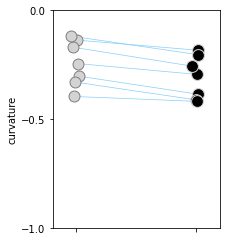

In [14]:
print("curvature minima values:")
seed = 4

plt.figure(figsize=(3,4))
var1 = (minC_val_ls)
var2 = (minM_val_ls)

seed = 4
np.random.seed(seed)
x1 = np.random.normal(0,0.03,len(var1))
x2 = np.random.normal(1,0.03,len(var2))

plt.scatter(x1,var1,color="lightgrey",edgecolor='grey',s=120,zorder=10)
plt.scatter(x2,var2,color='k',edgecolor='lightgrey',s=140,zorder=10)

for i in range(len(var1)):
    plt.plot([x1[i],x2[i]],[var1[i],var2[i]],lw=0.7,color='lightskyblue')
plt.xlim(-0.2,1.2)
plt.ylim(-1,0)
plt.xticks([0, 1], [])
plt.yticks([-1,-0.5, 0])
plt.ylabel('curvature')
plt.show()

curvature minima positions:


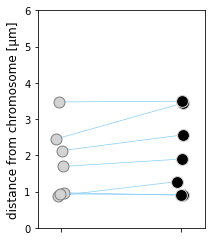

In [105]:
print("curvature minima positions:")
seed = 4

plt.figure(figsize=(3,4))
var1 = (minC_pos_ls)
var2 = (minM_pos_ls)

np.random.seed(seed)
x1 = np.random.normal(0,0.03,len(var1))
x2 = np.random.normal(1,0.03,len(var2))

plt.scatter(x1,var1,color="lightgrey",edgecolor='grey',s=120,zorder=10)
plt.scatter(x2,var2,color='k',edgecolor='lightgrey',s=140,zorder=10)

for i in range(len(var1)):
    plt.plot([x1[i],x2[i]],[var1[i],var2[i]],lw=0.7,color='lightskyblue')
plt.xlim(-0.2,1.2)
plt.ylim(0,6)
plt.xticks([0, 1], [])
plt.yticks([0,1,2,3,4,5, 6])
plt.ylabel('distance from chromosome [μm]', fontsize=12)
plt.savefig('fig_outputs/curv_min_positions.pdf')
plt.show()

Inflection points:


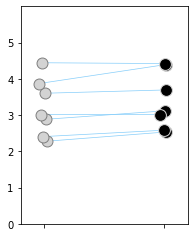

In [92]:
print("Inflection points:")
seed = 4

plt.figure(figsize=(3,4))
var1 = (inflectionC_pos_ls)
var2 = (inflectionM_pos_ls)

np.random.seed(seed)
x1 = np.random.normal(0,0.03,len(var1))
x2 = np.random.normal(1,0.03,len(var2))

plt.scatter(x1,var1,color="lightgrey",edgecolor='grey',s=120,zorder=10)
plt.scatter(x2,var2,color='k',edgecolor='lightgrey',s=140,zorder=10)

for i in range(len(var1)):
    plt.plot([x1[i],x2[i]],[var1[i],var2[i]],lw=0.7,color='lightskyblue')
plt.xlim(-0.2,1.2)
plt.ylim(0,6)
plt.xticks([0, 1], [])
plt.yticks([0, 1, 2, 3, 4, 5])
# plt.savefig('fig_outputs/inflection_positions.pdf')
plt.show()

curvature minima positions:


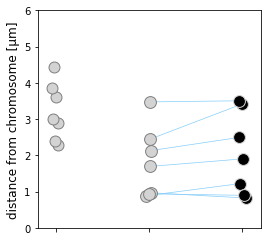

In [104]:
print("curvature minima positions:")
seed = 4

plt.figure(figsize=(4.0,4))
var1 = (inflectionC_pos_ls)
var2 = (minC_pos_ls)
var3 = xC_ls

np.random.seed(seed)
x1 = np.random.normal(0,0.03,len(var1))
x2 = np.random.normal(1,0.03,len(var2))
x3 = np.random.normal(2,0.03,len(var3))

plt.scatter(x1,var1,color="lightgrey",edgecolor='grey',s=120,zorder=10)
plt.scatter(x2,var2,color="lightgrey",edgecolor='grey',s=140,zorder=10)
plt.scatter(x3,var3,color='k',edgecolor='lightgrey',s=140,zorder=10)

for i in range(len(var1)):
    plt.plot([x2[i],x3[i]],[var2[i],var3[i]],lw=0.7,color='lightskyblue')
    
plt.xlim(-0.2,2.2)
plt.ylim(0,6)
plt.xticks([0, 1, 2], [])
plt.yticks([0,1,2,3,4,5,6])
plt.ylabel('distance from chromosome [μm]', fontsize=12)
plt.savefig('fig_outputs/inflection_vs_curvemin_vs_xC.pdf')
plt.show()

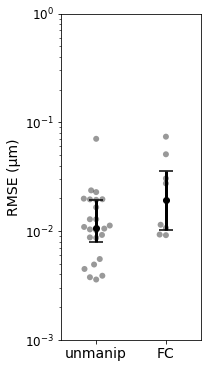

In [115]:
rmse_unmanip = [0.01036088, 0.0705788 , 0.00921754, 0.01957098, 0.00376231,
                0.00388408, 0.01962497, 0.00553303, 0.00492511, 0.02283475,
                0.0044831 , 0.01091403, 0.01988468, 0.02368407, 0.01054113,
                0.01124329, 0.0087474 , 0.01283972, 0.01284662, 0.0035849 ,
                0.01018786, 0.01937117, 0.01653882, 0.00866237]

RMSE_avg = np.median(rmse_ls)
RMSE_25 = np.percentile(rmse_ls, 25)
RMSE_75 = np.percentile(rmse_ls, 75)

RMSE_avg_un = np.median(rmse_unmanip)
RMSE_25_un = np.percentile(rmse_unmanip, 25)
RMSE_75_un = np.percentile(rmse_unmanip, 75)

plt.subplots(figsize=(2.5, 6.0))

sns.swarmplot(data=[rmse_unmanip, rmse_ls], palette = ["k"], size = 6, orient='v', alpha=0.4)

plt.scatter(1, RMSE_avg, color='k')
plt.errorbar(1, RMSE_avg, yerr = [[RMSE_avg-RMSE_25],[RMSE_75-RMSE_avg]], \
             elinewidth = 3, fmt = '_', color = "k", marker = '_', markersize = 5, \
             capsize = 7, zorder = 10, capthick=1.5)

plt.scatter(0, RMSE_avg_un, color='k')
plt.errorbar(0, RMSE_avg_un, yerr = [[RMSE_avg_un-RMSE_25_un],[RMSE_75_un-RMSE_avg_un]], \
             elinewidth = 3, fmt = '_', color = "k", marker = '_', markersize = 5, \
             capsize = 7, zorder = 10, capthick=1.5)

plt.yscale('log')
plt.yticks([0.001, 0.01, 0.1, 1.0], fontsize=12)
plt.xticks([0, 1], ['unmanip', 'FC'], fontsize=14)
plt.ylabel('RMSE (μm)', fontsize=14)
plt.savefig('fig_outputs/RMSE_FC.pdf')

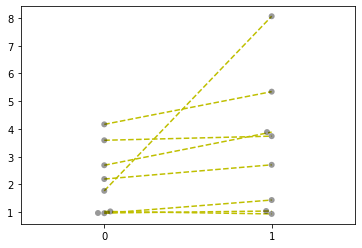

In [121]:
sns.swarmplot(data=[minC_pos_ls, minM_pos_ls], palette = ["k"], size = 6, orient='v', alpha=0.4)
for i in range(len(minC_pos_ls)):
    plt.plot([0, 1], [minC_pos_ls[i], minM_pos_ls[i]], color='y', ls='--')

xC: 4.410
FC: 1.839
Error (um): 0.02714
x_curve_min (model): 4.402


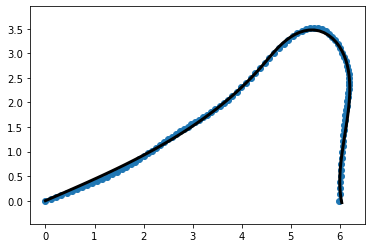

In [86]:
# xC_init = 2.0
# FC_init = 0.01
# Rx_init = Rx_opt
# M0_init = 1e5
# Ry_init = Ry_opt
# theta0_init = theta0_opt
# F_init = F_opt
# xF_init = xF_opt



# # p_mcmc = np.array([Rx, M0, Ry, theta0, F, xF, xC, FC])

# length_conserved = False
# end_match = False
# M0_zero = True

# if n==0:
#     p_mcmc = np.array([-6.09412389e-01, -9.03422087e+01, -7.82310908e-02,  1.93568401e-01,
#                        -1.01458394e+00,  5.49533607e+00,  2.49315635e+00,  4.12598290e-01])
# elif n==1:
#     p_mcmc = np.array([-0.62397266,   5.70264011,  -0.05769978,   0.25821882,
#                         1.67328158,   4.62798007,   1.90316205,   0.7380843])
# elif n==2:
#     p_mcmc = np.array([-0.23266218,  0.50601652,  0.10848743,  0.36072373,  0.7464032 ,
#                         4.98798715,  1.22111608,  0.48923246])
# elif n==3:
#     p_mcmc = np.array([-1.30743247e-01, -3.93350056e+05,  4.44981790e-01,  2.56502336e-01,
#                         8.61470869e-01,  4.72392525e+00,  8.21061583e-01,  8.53081029e-01])
# elif n==4:
#     p_mcmc = np.array([-3.36690748e-01,  7.78617265e+03,  3.90323169e-01,  1.74620280e-01,
#                         1.39632545e+00,  4.75345564e+00,  8.95434749e-01,  9.18206878e-01])
# elif n==5:
#     p_mcmc = np.array([-0.82382336,  1.12602874, -0.34647815,  0.41005571, -2.96837728,
#                         5.66736376,  3.41776434,  0.7978696])
# elif n==6:
#     p_mcmc = np.array([-1.97395838e-02, -6.43787623e+02,  2.65541519e-02,  4.08015200e-01,
#                        -2.99771839e+00,  5.48920824e+00,  4.41040238e+00,  1.83931817e+00])
# elif n==7:
#     p_mcmc = np.array([-4.32353424e-01,  4.14473863e+00,  1.71639645e-02,  8.45305132e-02,
#                        -2.38547450e+00,  5.63546962e+00,  3.50500693e+00,  1.20291030e+00])

p_mcmc = np.array([-1.97395838e-02, -6.43787623e+02,  2.65541519e-02,  4.08015200e-01,
                    -2.99771839e+00,  5.48920824e+00,  4.41040238e+00,  1.83931817e+00])
                   
                   
xC_opt = p_mcmc[-2]
print('xC: %.3f' % xC_opt)
FC_opt = p_mcmc[-1]
print('FC: %.3f' % FC_opt)
res = res_fn_exact_FC(p_mcmc, x_dat, y_dat, xF, sigma_xF, \
                      length_conserved=length_conserved, M0_zero=M0_zero, end_match=end_match)
print('Error (um): %.5f' % np.mean(res))

output_deflection = deflection_exact_FC(p_mcmc, x_dat, y_dat, xF, sigma_xF, length_conserved, M0_zero)
x_mod_FC, y_mod_FC, M_mod_FC, _, _, _ = output_deflection

_, ind_pairs = distances_pair_min(x_dat, y_dat, x_mod_FC, y_mod_FC)
ind_pairs = ind_pairs.astype('int')
x_mod_FC_truncated = x_mod_FC[:ind_pairs[-1]+1]
y_mod_FC_truncated = y_mod_FC[:ind_pairs[-1]+1]
M_mod_FC_truncated = M_mod_FC[:ind_pairs[-1]+1]

x_curve_min = x_mod_FC[np.where(M_mod_FC_truncated[x_mod_FC_truncated < xF] == \
                                M_mod_FC_truncated[x_mod_FC_truncated < xF].min())]
print('x_curve_min (model): %.3f' % x_curve_min)

plt.scatter(x_dat, y_dat)
plt.plot(x_mod_FC_truncated, y_mod_FC_truncated, color='k', lw=3.0)
plt.axis('equal')
plt.show()



# Rx_init = p_mcmc[0]
# M0_init = p_mcmc[1]
# Ry_init = p_mcmc[2]
# theta0_init = p_mcmc[3]
# F_init = p_mcmc[4]
# xF_init = p_mcmc[5]
# xC_init = p_mcmc[6]
# FC_init = p_mcmc[7]

In [40]:
# res = res_fn_exact_FC(p_mcmc, x_dat, y_dat, xF, sigma_xF, \
#                       length_conserved=length_conserved, M0_zero=M0_zero, end_match=end_match)
# print('Error (um): %.5f' % np.mean(res))

In [53]:
def logpost_exact(param, x_dat, y_dat, xF, sigma_xF, \
                  length_conserved=True, M0_zero=False, end_match=False):
    
    Rx, M0, Ry, theta0, F, xF_var, xC, FC = param
    L = x_dat.max()-x_dat.min()
    
    if np.abs(M0) > 1e10:
        return -np.inf
    if theta0 < 0.0 or theta0 > 1.0:
        return -np.inf
    if Rx > 0:
        return -np.inf
    if (xC < 0) or (xC > L) or (xF_var < 0) or (xF_var>L):
        return -np.inf
    if np.abs(Rx) > 3 or np.abs(Ry) > 1.5 or np.abs(F) > 3 or np.abs(FC) > 3:
        return -np.inf
    
    res = res_fn_exact_FC(param, x_dat, y_dat, xF, sigma_xF, \
                          length_conserved=length_conserved, M0_zero=M0_zero, end_match=end_match)
                          
    return -15*np.log(np.sum(res))
    
    
    
n_dim = 8      # number of parameters in the model
n_walkers = 30   # number of MCMC walkers
n_burn = 500   # "burn-in" period to let chains stabilize
n_steps = 50000   # number of MCMC steps to take after burn-in

sigma_start = 0.01

# p0[i,j] is the starting point for walker i along variable j.    
param_init = np.empty((n_walkers, n_dim))
param_init[:,0] = Rx_init*np.random.normal(1.0, sigma_start, n_walkers)
param_init[:,1] = np.random.normal(1.0, sigma_start, n_walkers)
param_init[:,2] = Ry_init*np.random.normal(1.0, sigma_start, n_walkers)
param_init[:,3] = theta0_init*np.random.normal(1.0, sigma_start, n_walkers)
param_init[:,4] = F_init*np.random.normal(1.0, sigma_start, n_walkers)
param_init[:,5] = xF_init*np.random.normal(1.0, sigma_start, n_walkers)
param_init[:,6] = xC_init*np.random.normal(1.0, sigma_start, n_walkers)
param_init[:,7] = FC_init*np.random.normal(1.0, sigma_start, n_walkers)


args = (x_dat, y_dat, xF, sigma_xF, length_conserved, M0_zero, end_match)

sampler = emcee.EnsembleSampler(n_walkers, n_dim, logpost_exact, 
                                args=args, threads=3)

In [54]:
pos, prob, state = sampler.run_mcmc(param_init, n_burn, progress=True)

100%|██████████| 500/500 [00:11<00:00, 43.62it/s]


In [55]:
sampler = emcee.EnsembleSampler(n_walkers, n_dim, logpost_exact, 
                                args=args, threads=3)
_ = sampler.run_mcmc(pos, n_steps, progress=True)

100%|██████████| 50000/50000 [19:12<00:00, 43.38it/s]


In [58]:
cols = ['Rx', 'M0', 'Ry', 'theta0', 'F', 'xF_var', 'xC', 'FC']
df_mcmc = sampler_to_dataframe(sampler, columns=cols)

In [59]:
df_mcmc[df_mcmc['lnprob']==df_mcmc['lnprob'].max()]

,Rx,M0,Ry,theta0,F,xF_var,xC,FC,lnprob,chain
592827,-0.872743,0.997705,-0.488088,0.503175,1.340452,4.618851,2.002819,0.010307,145.215314,11
592857,-0.872743,0.997705,-0.488088,0.503175,1.340452,4.618851,2.002819,0.010307,145.215314,11
592887,-0.872743,0.997705,-0.488088,0.503175,1.340452,4.618851,2.002819,0.010307,145.215314,11
592917,-0.872743,0.997705,-0.488088,0.503175,1.340452,4.618851,2.002819,0.010307,145.215314,11
592947,-0.872743,0.997705,-0.488088,0.503175,1.340452,4.618851,2.002819,0.010307,145.215314,11
...,...,...,...,...,...,...,...,...,...,...
1499877,-0.872743,0.997705,-0.488088,0.503175,1.340452,4.618851,2.002819,0.010307,145.215314,29
1499907,-0.872743,0.997705,-0.488088,0.503175,1.340452,4.618851,2.002819,0.010307,145.215314,29
1499937,-0.872743,0.997705,-0.488088,0.503175,1.340452,4.618851,2.002819,0.010307,145.215314,29
1499967,-0.872743,0.997705,-0.488088,0.503175,1.340452,4.618851,2.002819,0.010307,145.215314,29


In [60]:
print(df_mcmc['lnprob'].max())
df_mcmc.loc[[78773]].values[0]

145.21531406897523


array([-1.00005918e+00,  1.05260582e+00, -5.71138544e-01,  5.16008588e-01,
        1.25791148e+00,  4.63218606e+00,  1.58493568e+00,  9.57019438e-03,
        5.54698252e+01,  1.00000000e+00])

In [270]:
@numba.njit
def deflection_exact_FC(param, L_contour, n_div=100):
    
    Rx, M0, Ry, theta0, F, xF, xC, FC = param
    
    n_steps = int(1.15*n_div)
    
    x_ls = np.zeros(n_steps)
    y_ls = np.zeros(n_steps)
    M_ls = np.zeros(n_steps)
    theta_ls = np.zeros(n_steps)
    
    theta_ls[0] = theta0
    found_F = False
    yF = 0
    thetaF = np.pi/2
    ds = L_contour/n_div
    
    
    for i in range(n_steps-1):
 
        xF_sign = np.sign(xF) * np.sign(xF - x_ls[i])
        if xF_sign < 0 and found_F == False:
            found_F = True
            
            iF = i-1
            yF = interpolate_two_pt(xF, x_ls[iF], x_ls[iF+1], y_ls[iF], y_ls[iF+1])
            thetaF = np.pi/2 + np.arctan2(y_ls[iF+1]-y_ls[iF], x_ls[iF+1]-x_ls[iF])
            Fx = F * np.cos(thetaF)
            Fy = F * np.sin(thetaF)
            
            
        M = M0 + Rx*y_ls[i] - Ry*x_ls[i]
        if found_F:
            M += Fx*(y_ls[i]-yF) - Fy*(x_ls[i]-xF)
        if x_ls[i] >= xC and xC > 0:
            M -= FC*(xC-x_ls[i]) 
            
        
        
        theta_mid = theta_ls[i] - ds/2*M
        y_mid = y_ls[i] + ds/2*np.sin(theta_mid)
        x_mid = x_ls[i] + ds/2*np.cos(theta_mid)
        
        
        M_mid = M0 + Rx*y_mid - Ry*x_mid
        if found_F:
            M_mid += Fx*(y_mid-yF) - Fy*(x_mid-xF)
        if x_mid >= xC and xC > 0:
            M_mid -= FC*(xC-x_mid) 
            
        theta_ls[i+1] = theta_ls[i] - ds*M_mid
        x_ls[i+1] = x_ls[i] + ds*np.cos(theta_mid)
        y_ls[i+1] = y_ls[i] + ds*np.sin(theta_mid)
        M_ls[i+1] = M_mid 
        
    return x_ls, y_ls, M_ls, xF, yF, thetaF

    
def res_fn_exact_FC(param, L_contour, x_dat, y_dat, end_match=False, n_dense=500):
    
    output_deflection = deflection_exact_FC(param, L_contour)
    
    x_mod = output_deflection[0]
    y_mod = output_deflection[1]
    
    
    s_mod, _ = contour_fn(x_mod, y_mod)
    s_mod_dense = np.linspace(s_mod[0], s_mod[-1], n_dense)
    
    fx = interpolate.interp1d(s_mod, x_mod)
    x_dense = fx(s_mod_dense)
    
    fy = interpolate.interp1d(s_mod, y_mod)
    y_dense = fy(s_mod_dense)
    
    
    res, _ = distances_pair_min(x_dat, y_dat, x_dense, y_dense)
    
    if end_match:
        extra = np.max([res[-1], L_contour/100])
        res *= extra
        
    return res

In [285]:
def logpost_exact(param, L_contour, x_dat, y_dat, xF_guess, sigma_xF, \
                  M0_zero, FC_zero, end_match):
    
    Rx, M0, Ry, theta0, F, xF, xC, FC = param
    
    if M0_zero:
        M0 = 0
    if FC_zero:
        FC = 0
    
    param = Rx, M0, Ry, theta0, F, xF, xC, FC
    
    L = x_dat.max()-x_dat.min()
    
    if F < 0:
        return -np.inf
    if Rx > 0:
        return -np.inf
    if np.abs(xF - xF_guess) > sigma_xF:
        return -np.inf
    if np.abs(M0) > 1e2:
        return -np.inf
    if theta0 < 0.0 or theta0 > 1.0:
        return -np.inf
    if (xC < 0) or (xC > L) or (xF < 0) or (xF>L):
        return -np.inf
    if np.abs(Rx) > 3 or np.abs(Ry) > 1.5 or np.abs(F) > 3 or np.abs(FC) > 3:
        return -np.inf
    
    res = res_fn_exact_FC(param, L_contour, x_dat, y_dat, end_match)
    
    return -10*np.log(np.sum(res))

In [286]:
cells = sorted(glob.glob("../../dat/WT_manip/20*"))

fin_track_ls = []
for cell in cells:
    kfibers = sorted(glob.glob(cell+"/kfiber_*.csv"))
    final_kfiber = kfibers[-1]
    fin_track_ls.append(final_kfiber)
    
df_fin = pd.DataFrame(columns = ["Spindle", "x_dat", "y_dat", "x_mod", "y_mod", "M_mod", "L", \
                                 "Rx", "M0", "Ry", "Fx", "Fy", "xF", "yF", "theta0", \
                                 "largest-y-diff (error)", "Quality of fit (error)"])

In [294]:
end_match = False
M0_zero = True

sigma_xF = 0.5

n_dim = 8        # number of parameters in the model
n_walkers = 30   # number of MCMC walkers
n_steps = 12000   # number of MCMC steps to take after burn-in
n_filter = 1     # number of sampling restarts from the optimal position

sigma_start = 0.2
cols = ['Rx', 'M0', 'Ry', 'theta0', 'F', 'xF', 'xC', 'FC']

In [295]:
p_init_FC_zero = np.array([-0.62397266,   1e-8,  -0.05769978,   0.25821882,
                            1e-8,   xF_guess,   1.90316205,   1e-8])

In [296]:
# p_init_general = np.array([-0.62397266,   1e-8,  -0.05769978,   0.25821882,
#                             1.67328158,   xF_guess,   1.90316205,   0.7380843])

In [297]:
# p_init_general = np.array([-0.61, 1.0e-10, -0.078,  0.19, -1.0,  xF_guess,  2.50,  0.41])
# [i,j]-th element is the starting point for walker i on the variable j axis
p_init_mat = np.tile(p_init_FC_zero, (n_walkers, 1))

  0%|          | 0/12000 [00:00<?, ?it/s]/Users/vahegalstyan/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 12000/12000 [02:25<00:00, 82.60it/s]


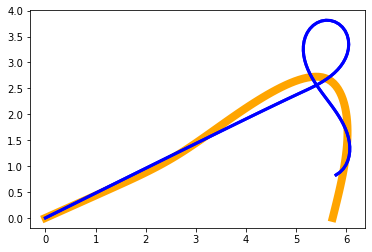

In [298]:
for n, kfib in enumerate(fin_track_ls):
    
    if n!=5:
        continue
        
    cell = cells[n]
    spindle = cell.split("/")[-1].split(".")[0]
    df_dat = pd.read_csv(kfib,engine="python")
    
    x_dat = df_dat["X"].values
    y_dat = df_dat["Y"].values
    
    
    angle = np.arctan((y_dat[-1] - y_dat[0]) / (x_dat[-1] - x_dat[0]))
    x_dat,y_dat = rotate(x_dat,y_dat,angle)

    # Translation to start at origin
    x_dat -= x_dat[0]
    y_dat -= y_dat[0]

    # Flipping to ensure a positive initial slope
    theta0 = np.arctan2(y_dat[3]-y_dat[0], x_dat[3]-x_dat[0])
    if theta0 < 0.0:
        y_dat = -y_dat
        angle = -angle

    # Convert from pixel to micron units based on scope camera calibration
    is_2017 = re.search('2017',cell)
    if is_2017:
        scope_calibration = 1/0.0657
    else:
        scope_calibration = 1/0.105

    x_dat = x_dat/scope_calibration
    y_dat = y_dat/scope_calibration
    
    # P-K distance
    L = x_dat[-1] - x_dat[0]
    
    
    # Flip the profile
    y_dat = np.flip(y_dat)
    x_dat = L - np.flip(x_dat)
    
    
    

    # Initial angle
    theta_init = np.arctan2(y_dat[3]-y_dat[0], x_dat[3]-x_dat[0])

    y_needle = np.max(y_dat)
    x_needle = x_dat[np.where(y_dat == np.max(y_dat))]
    xF_guess = x_needle[0]

    # Contour length
    _, L_contour = contour_fn(x_dat, y_dat)
    
    
    
    
    
    
    # -------------------- MCMC -------------------- #
    FC_zero = True
    args = (L_contour, x_dat, y_dat, xF_guess, sigma_xF, M0_zero, FC_zero, end_match)
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, logpost_exact, args=args, threads=3)
    
    p_opt_mat = p_init_mat
    for k in range(n_filter):
        for j in range(n_dim):
            p_opt_mat[:,j] *= np.random.normal(1.0, sigma_start, n_walkers)
        _ = sampler.run_mcmc(p_opt_mat, n_steps, progress=True)
        df_mcmc = sampler_to_dataframe(sampler, columns=cols)
        p_opt = df_mcmc[df_mcmc['lnprob']==df_mcmc['lnprob'].max()].values[0][:-2]
        for j in range(n_dim):
            p_opt_mat[:,j] = p_opt[j]*np.random.normal(1.0, sigma_start, n_walkers)
            
#     FC_zero = False
#     args = (L_contour, x_dat, y_dat, xF_guess, sigma_xF, M0_zero, FC_zero, end_match)
#     sampler = emcee.EnsembleSampler(n_walkers, n_dim, logpost_exact, args=args, threads=3)
    
#     for k in range(n_filter):
#         for j in range(n_dim):
#             p_opt_mat[:,j] *= np.random.normal(1.0, sigma_start, n_walkers)
#         _ = sampler.run_mcmc(p_opt_mat, n_steps, progress=True)
#         df_mcmc = sampler_to_dataframe(sampler, columns=cols)
#         p_opt = df_mcmc[df_mcmc['lnprob']==df_mcmc['lnprob'].max()].values[0][:-2]
#         for j in range(n_dim):
#             p_opt_mat[:,j] = p_opt[j]*np.random.normal(1.0, sigma_start, n_walkers)
    # --------------------------------------------- #
    
    if M0_zero:
        p_opt[1] = 0
    if FC_zero:
        p_opt[-1] = 0
        
    output_deflection = deflection_exact_FC(p_opt, L_contour)
    x_mod_FC, y_mod_FC, _, _, _, _ = output_deflection

    _, ind_pairs = distances_pair_min(x_dat, y_dat, x_mod_FC, y_mod_FC)
    ind_pairs = ind_pairs.astype('int')
    x_mod_FC_truncated = x_mod_FC[:ind_pairs[-1]+1]
    y_mod_FC_truncated = y_mod_FC[:ind_pairs[-1]+1]

    plt.plot(x_dat,y_dat, color="orange", lw = 8)
    plt.plot(x_mod_FC, y_mod_FC, color = "blue", lw = 3)
    plt.plot(x_mod_FC_truncated, y_mod_FC_truncated, color = "blue", lw = 3)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    

    
    
#     Rx_opt, M0_opt, Ry_opt, theta0_opt, F_opt, _ = p_opt
#     F_opt = np.abs(F_opt)
#     Fx_opt = F_opt * np.cos(thetaF)
#     Fy_opt = F_opt * np.sin(thetaF)

#     plt.axvline(xF, color='k', ls='--', alpha=0.4)

#     quiver_scale=1
#     plt.quiver(0, 0, Rx_opt, Ry_opt, color='k', scale=quiver_scale, zorder = 20)
#     plt.quiver(xF_final, yF, Fx_opt, abs(Fy_opt), color='k', scale=quiver_scale, zorder = 20)
# #     plt.quiver(L,0,-(Rx_opt+Fx_opt),-(Ry_opt+Fy_opt), color='k',scale=quiver_scale, zorder = 20)
#     plt.xlabel('x (μm)')
#     plt.ylabel('y (μm)')
#     plt.axis('equal')
    
    

#     res_exact = res_fn_exact(p_opt, x_dat, y_dat, xF, sigma_xF, length_conserved, M0_zero, end_match)
#     err_exact = np.sqrt(np.mean(res_exact**2))

    
#     df_fin = df_fin.append({'Spindle': spindle,
#                             'x_dat': x_dat,
#                             'y_dat': y_dat,
#                             'x_mod': x_mod,
#                             'y_mod': y_mod,
#                             'M_mod': M_mod,
#                             'L': L,
#                             'Rx': Rx_opt,
#                             'M0': M0_opt,
#                             'Ry': Ry_opt,
#                             'Fx': Fx_opt,
#                             'Fy': Fy_opt,
#                             'xF': xF,
#                             'yF': yF,                            
#                             'theta0': theta0_opt,
#                             'largest-y-diff (error)': y_diff_max, 
#                             'Root-mean-square(error)': err_exact}, ignore_index=True)

    plt.show()
    break

In [299]:
df_mcmc[df_mcmc['lnprob']==df_mcmc['lnprob'].max()]

,Rx,M0,Ry,theta0,F,xF,xC,FC,lnprob,chain
200763,-1.14541,-1.761092e+08,-0.548937,0.446825,1.033222,5.080659,3.059763,2.723367e+09,-25.607802,16
200793,-1.14541,-1.761092e+08,-0.548937,0.446825,1.033222,5.080659,3.059763,2.723367e+09,-25.607802,16
200823,-1.14541,-1.761092e+08,-0.548937,0.446825,1.033222,5.080659,3.059763,2.723367e+09,-25.607802,16
200853,-1.14541,-1.761092e+08,-0.548937,0.446825,1.033222,5.080659,3.059763,2.723367e+09,-25.607802,16
200883,-1.14541,-1.761092e+08,-0.548937,0.446825,1.033222,5.080659,3.059763,2.723367e+09,-25.607802,16
200913,-1.14541,-1.761092e+08,-0.548937,0.446825,1.033222,5.080659,3.059763,2.723367e+09,-25.607802,16
200943,-1.14541,-1.761092e+08,-0.548937,0.446825,1.033222,5.080659,3.059763,2.723367e+09,-25.607802,16
200973,-1.14541,-1.761092e+08,-0.548937,0.446825,1.033222,5.080659,3.059763,2.723367e+09,-25.607802,16
201003,-1.14541,-1.761092e+08,-0.548937,0.446825,1.033222,5.080659,3.059763,2.723367e+09,-25.607802,16
201033,-1.14541,-1.761092e+08,-0.548937,0.446825,1.033222,5.080659,3.059763,2.723367e+09,-25.607802,16


In [293]:
# cols = ['Rx', 'M0', 'Ry', 'theta0', 'F', 'xF', 'xC', 'FC']
p_opt

array([-1.23926717,  0.        , -0.60405095,  0.45375308,  1.00833767,
        5.20073137,  1.64866041,  0.        ])

In [ ]:
p_mcmc = np.array([-0.82382336,  0.0, -0.34647815,  0.41005571, 2.96837728,
                    5.66736376,  3.41776434,  0.7978696])

In [235]:
xF

5.378263490815992

(array([-2., -1.,  0.,  1.,  2.,  3.]),
 <a list of 6 Text major ticklabel objects>)

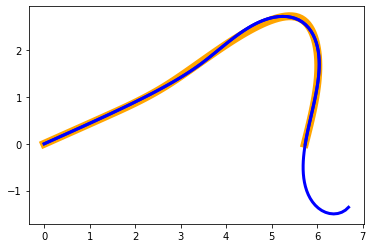

In [237]:
output_deflection = deflection_exact_FC_1(p_mcmc, L_contour)
# output_deflection = deflection_exact_FC_2(p_mcmc, x_dat, y_dat, 5.66736376, sigma_xF)
# param, x_dat, y_dat, xF, sigma_xF, \
#                         length_conserved=True, M0_zero=False, n_div=100):
x_mod_FC, y_mod_FC, _, _, _, _ = output_deflection

_, ind_pairs = distances_pair_min(x_dat, y_dat, x_mod_FC, y_mod_FC)
ind_pairs = ind_pairs.astype('int')
x_mod_FC_truncated = x_mod_FC[:ind_pairs[-1]+1]
y_mod_FC_truncated = y_mod_FC[:ind_pairs[-1]+1]

plt.plot(x_dat,y_dat, color="orange", lw = 8)
plt.plot(x_mod_FC, y_mod_FC, color = "blue", lw = 3)
plt.plot(x_mod_FC_truncated, y_mod_FC_truncated, color = "blue", lw = 3)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

xC: 3.418
FC: 0.798
Error (um): 0.01944
x_curve_min (model): 3.438


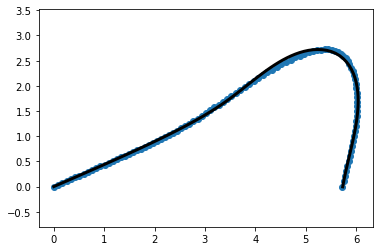

In [247]:
# p_mcmc = np.array([Rx, M0, Ry, theta0, F, xF, xC, FC])
if n==0:
    p_mcmc = np.array([-6.09412389e-01, -9.03422087e+01, -7.82310908e-02,  1.93568401e-01,
                       -1.01458394e+00,  5.49533607e+00,  2.49315635e+00,  4.12598290e-01])
elif n==1:
    p_mcmc = np.array([-0.62397266,   5.70264011,  -0.05769978,   0.25821882,
                        1.67328158,   4.62798007,   1.90316205,   0.7380843])
elif n==2:
    p_mcmc = np.array([-0.23266218,  0.50601652,  0.10848743,  0.36072373,  0.7464032 ,
                        4.98798715,  1.22111608,  0.48923246])
elif n==3:
    p_mcmc = np.array([-1.30743247e-01, -3.93350056e+05,  4.44981790e-01,  2.56502336e-01,
                        8.61470869e-01,  4.72392525e+00,  8.21061583e-01,  8.53081029e-01])
elif n==4:
    p_mcmc = np.array([-3.36690748e-01,  7.78617265e+03,  3.90323169e-01,  1.74620280e-01,
                        1.39632545e+00,  4.75345564e+00,  8.95434749e-01,  9.18206878e-01])
elif n==5:
    p_mcmc = np.array([-0.82382336,  1.12602874, -0.34647815,  0.41005571, -2.96837728,
                        5.66736376,  3.41776434,  0.7978696])
elif n==6:
    p_mcmc = np.array([-1.97395838e-02, -6.43787623e+02,  2.65541519e-02,  4.08015200e-01,
                       -2.99771839e+00,  5.48920824e+00,  4.41040238e+00,  1.83931817e+00])
elif n==7:
    p_mcmc = np.array([-4.32353424e-01,  4.14473863e+00,  1.71639645e-02,  8.45305132e-02,
                       -2.38547450e+00,  5.63546962e+00,  3.50500693e+00,  1.20291030e+00])

xC_opt = p_mcmc[-2]
print('xC: %.3f' % xC_opt)
FC_opt = p_mcmc[-1]
print('FC: %.3f' % FC_opt)
res = res_fn_exact_FC(p_mcmc, x_dat, y_dat, xF, sigma_xF, \
                      length_conserved=length_conserved, M0_zero=M0_zero, end_match=end_match)
print('Error (um): %.5f' % np.mean(res))

output_deflection = deflection_exact_FC(p_mcmc, x_dat, y_dat, xF, sigma_xF, length_conserved, M0_zero)
x_mod_FC, y_mod_FC, M_mod_FC, _, _, _ = output_deflection

_, ind_pairs = distances_pair_min(x_dat, y_dat, x_mod_FC, y_mod_FC)
ind_pairs = ind_pairs.astype('int')
x_mod_FC_truncated = x_mod_FC[:ind_pairs[-1]+1]
y_mod_FC_truncated = y_mod_FC[:ind_pairs[-1]+1]
M_mod_FC_truncated = M_mod_FC[:ind_pairs[-1]+1]

x_curve_min = x_mod_FC[np.where(M_mod_FC_truncated[x_mod_FC_truncated < xF] == \
                                M_mod_FC_truncated[x_mod_FC_truncated < xF].min())]
print('x_curve_min (model): %.3f' % x_curve_min)

plt.scatter(x_dat, y_dat)
plt.plot(x_mod_FC_truncated, y_mod_FC_truncated, color='k', lw=3.0)
plt.axis('equal')
plt.show()

In [248]:
res = res_fn_exact_FC(p_mcmc, x_dat, y_dat, xF, sigma_xF, \
                      length_conserved=length_conserved, M0_zero=M0_zero, end_match=end_match)
print('Error (um): %.5f' % np.mean(res))

Error (um): 0.01944


In [227]:
n_dim = 8      # number of parameters in the model
n_walkers = 30   # number of MCMC walkers
n_burn = 500   # "burn-in" period to let chains stabilize
n_steps = 50000   # number of MCMC steps to take after burn-in

sigma_start = 0.01

# p0[i,j] is the starting point for walker i along variable j.    
param_init = np.empty((n_walkers, n_dim))
param_init[:,0] = Rx_init*np.random.normal(1.0, sigma_start, n_walkers)
param_init[:,1] = np.random.normal(1.0, sigma_start, n_walkers)
param_init[:,2] = Ry_init*np.random.normal(1.0, sigma_start, n_walkers)
param_init[:,3] = theta0_init*np.random.normal(1.0, sigma_start, n_walkers)
param_init[:,4] = F_init*np.random.normal(1.0, sigma_start, n_walkers)
param_init[:,5] = xF_init*np.random.normal(1.0, sigma_start, n_walkers)
param_init[:,6] = xC_init*np.random.normal(1.0, sigma_start, n_walkers)
param_init[:,7] = FC_init*np.random.normal(1.0, sigma_start, n_walkers)


args = (x_dat, y_dat, xF, sigma_xF, length_conserved, M0_zero, end_match)

sampler = emcee.EnsembleSampler(n_walkers, n_dim, logpost_exact, 
                                args=args, threads=3)

In [228]:
pos, prob, state = sampler.run_mcmc(param_init, n_burn, progress=True)

  0%|          | 0/500 [00:00<?, ?it/s]/Users/vahegalstyan/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 500/500 [00:08<00:00, 56.09it/s]


In [229]:
sampler = emcee.EnsembleSampler(n_walkers, n_dim, logpost_exact, 
                                args=args, threads=3)
_ = sampler.run_mcmc(pos, n_steps, progress=True)

100%|██████████| 50000/50000 [12:43<00:00, 65.46it/s]


In [232]:
cols = ['Rx', 'M0', 'Ry', 'theta0', 'F', 'xF_var', 'xC', 'FC']
df_mcmc = sampler_to_dataframe(sampler, columns=cols)

# corner.corner(df_mcmc[cols]);
# https://emcee.readthedocs.io/en/stable/tutorials/monitor/

In [233]:
df_mcmc[df_mcmc['lnprob']==df_mcmc['lnprob'].max()]

,Rx,M0,Ry,theta0,F,xF_var,xC,FC,lnprob,chain
82502,-0.916699,-1.328189,-0.380238,0.405043,-2.960445,5.73171,3.199973,0.708181,-9.819592,1


In [234]:
print(df_mcmc['lnprob'].max())
df_mcmc.loc[[44635]].values[0]

-9.819592296880133


array([ -0.77517519,   0.64632969,  -0.33049133,   0.41626964,
        -2.65148158,   5.80620061,   3.30743895,   0.65761382,
       -14.32437498,   0.        ])